This Colab Notebook includes all the code nessesary to import, process, clean, augment, and train a YOLOv5 model to detect traffic signs using the Mapillary Traffic Sign Dataset. The bracketed number for each section refers to the associated section in the supporting report for this notebook.

This notebook does not contain the final algorithm deployment which can be found in the gihub repository: https://github.com/KieranPereira/Traffic-Sign-Detection

#  1. Imports and Installations (0.0)

In [1]:
!pip install pandas
import os
import shutil
import cv2
import json
import pandas as pd
from PIL import Image
from functools import *
import json
import time
import yaml
import zipfile
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import csv
import numpy as np
from google.colab.patches import cv2_imshow
!pip install gitpython
import glob


from sklearn.metrics import f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [2]:
#Linking Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Unzipping Data from Drive (3.1)

Between this step and the last, I compressed the Train and Validation folders that contained respective images and labels. I carried this out locally (compressing files on my computer and uploading them) as doing this through colab would have taken significantly longer

In [3]:
os.chdir("/content")

In [ ]:
#Unzipping Training files to Colab
with zipfile.ZipFile("/content/drive/MyDrive/Zipped Files/Train.zip","r") as zip_ref:
  zip_ref.extractall()

In [ ]:
#Unzipping Validation files to Colab
with zipfile.ZipFile("/content/drive/MyDrive/Zipped Files/Validation.zip","r") as zip_ref1:
  zip_ref1.extractall()

In [ ]:
#Unzipping Testing files to Colab
os.chdir("/content")
os.mkdir("Test")
os.chdir("/content/Test")

with zipfile.ZipFile("/content/drive/MyDrive/RoadSignDataset/Test/test.zip","r") as zip_ref:
  zip_ref.extractall()
with zipfile.ZipFile("/content/drive/MyDrive/RoadSignDataset/Test/test_annotations.zip","r") as zip_ref:
  zip_ref.extractall()

In [ ]:
#Unzipping random test files to Colab to evaluate performance of single images
if os.path.exists("/content/Original") ==True:
  shutil.rmtree("/content/Original")
os.chdir("/content")
os.mkdir("small_test")
os.chdir("small_test")
with zipfile.ZipFile("/content/drive/MyDrive/RoadSignDataset/Train/TEST/Original.zip","r") as zip_ref1:
  zip_ref1.extractall()

# 3. Dataset Manipulation (Mapillary Data) (3.1)


In [ ]:
#Reading information from json file to find class numbers - Creates labelstring which is used for yaml file later on. (Done locally on computer as colab takes a while.)
os.chdir("mtsd_v2_fully_annotated/annotations")
labelstring=[]
for file in os.listdir():
    with open(file,"r") as j:
        data = json.load(j)
        for instance in range(0,len(data["objects"])):
        #str(file).replace(".json",".txt")
            print(data["objects"][instance]["label"])
            with open("labelclasses.txt","w") as t:
                if str(data["objects"][instance]["label"]) not in labelstring:
                    labelstring.append(data["objects"][instance]["label"])
                for line in labelstring:
                    t.write("%s\n"%line)
# print("DONE")
with open("labelclasses.txt","r") as fp:
    x= len(fp.readlines())
    print("Total number of classes: ",x)
#Total number of classes = 401

In [ ]:
#Counting Number of files in folders (To ensure completeness)
while os.getcwd()!="/content":
  os.chdir("..")
count = 0
for entry in os.listdir("/content/drive/MyDrive/RoadSignDataset/Train/labels"):
  count= count+1
print(count)

In [ ]:
#counting splits
while os.getcwd()!="/content":
  os.chdir("..")
os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/splits")
with open("val.txt","r") as v:
  x= len(v.readlines())
  print(x)
with open("test.txt","r") as test:
  x= len(test.readlines())
  print(x)
with open("train.txt","r") as train:
  x= len(train.readlines())
  print(x)

In [ ]:
#Writing Class list yaml file- same as labelstring list made previously had to include this step to move list from Visual Studio Code to Colab:
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt") as f:
  class_list = f.readlines()
  class_list = [x.strip() for x in class_list]
print(class_list)

['other-sign', 'regulatory--keep-right--g1', 'regulatory--priority-over-oncoming-vehicles--g1', 'regulatory--height-limit--g1', 'regulatory--maximum-speed-limit-35--g2', 'warning--railroad-crossing-with-barriers--g1', 'warning--curve-left--g2', 'warning--falling-rocks-or-debris-right--g1', 'regulatory--keep-right--g4', 'warning--pedestrians-crossing--g4', 'complementary--go-right--g2', 'complementary--keep-left--g1', 'regulatory--maximum-speed-limit-45--g3', 'complementary--chevron-right--g3', 'regulatory--one-way-right--g2', 'regulatory--yield--g1', 'regulatory--one-way-straight--g1', 'warning--curve-right--g1', 'regulatory--pedestrians-only--g2', 'information--emergency-facility--g2', 'regulatory--no-entry--g1', 'warning--railroad-crossing--g3', 'warning--pedestrians-crossing--g5', 'warning--crossroads--g3', 'complementary--chevron-left--g5', 'information--motorway--g1', 'regulatory--no-stopping--g15', 'information--pedestrians-crossing--g1', 'warning--railroad-crossing-without-barri

# 4. Creating File Structure for YOLOv5 from Mapillary Data (3.1)


In [ ]:
#Moving Training files
os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_fully_annotated_images_train1 GREEN")
for entry in os.listdir():
  shutil.move(entry,"../Train/images")

os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_fully_annotated_images_train2 GREEN")
for entry in os.listdir():
  shutil.move(entry,"../Train/images")

os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_fully_annotated_images_train0/images")
for entry in os.listdir():
  shutil.move(entry,"../Train/images")

In [ ]:
#Moving Validation Files
while os.getcwd()!="/content":
  os.chdir("..")
print(os.getcwd())
os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_fully_annotated_images_val")
for entry in os.listdir():
  shutil.move(entry,"../Validation/images")

# 5. Initial Dataset Description (3.1)

In [ ]:
#Defining a function to count the number of unique classes
def Num_of_Classes(path):
  os.chdir(path)
  class_list= []
  for file in os.listdir(path):
    if ".txt" not in file:
      return "Incorrect path or check directory"
      break
    with open(str(file),"r") as text_file:
      for line in text_file:
        word_split = line.split()
        if word_split[0] not in class_list:
          class_list.append(word_split[0])
  return class_list
print("Number of Training Classes = {}".format(len(Num_of_Classes("/content/Train/labels"))))
print("Number of Validation Classes = {}".format(len(Num_of_Classes("/content/Validation/labels"))))

Number of Training Classes = 401
Number of Validation Classes = 391


In [ ]:
#Finding the number of instances for class

class_list = Num_of_Classes("/content/Train/labels")
class_list_final= []
for i in class_list:
  class_list_final.append(int(i))
class_list_final.sort()
line_num = -1
label_dict = {}
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt","r") as file:
  for line in file:
    if "\n" in line:
      line.replace("\n","")
    line_num +=1
    if line_num in class_list_final:
      label_dict[line_num] = line

In [ ]:
#Finding frequency for each class

os.chdir("/content/Train/labels")
label_dict1 = {}
Labels_with_freq = {}
for i in os.listdir():
  with open(str(i),"r") as file:
    for line in file:
      words_split = line.split()
      if words_split[0] in label_dict1:
        label_dict1[words_split[0]] += 1
      else:
        label_dict1[words_split[0]] = 1
for key, value in label_dict1.items():
  Labels_with_freq[label_dict[int(key)]] = value


In [ ]:
# Finding the number of classes defined as "other"
number_of_instances = 0
for key,value in Labels_with_freq.items():
  number_of_instances += value
print("Number of labels= {}".format(number_of_instances))
print("Percentage of \"other\" signs= {}%".format(int(Labels_with_freq['other-sign\n']/number_of_instances *100)))

Number of labels= 180286
Percentage of "other" signs= 65%


In [ ]:
#Removing "other" labelled instances for the bar chart plot
del Labels_with_freq['other-sign\n']

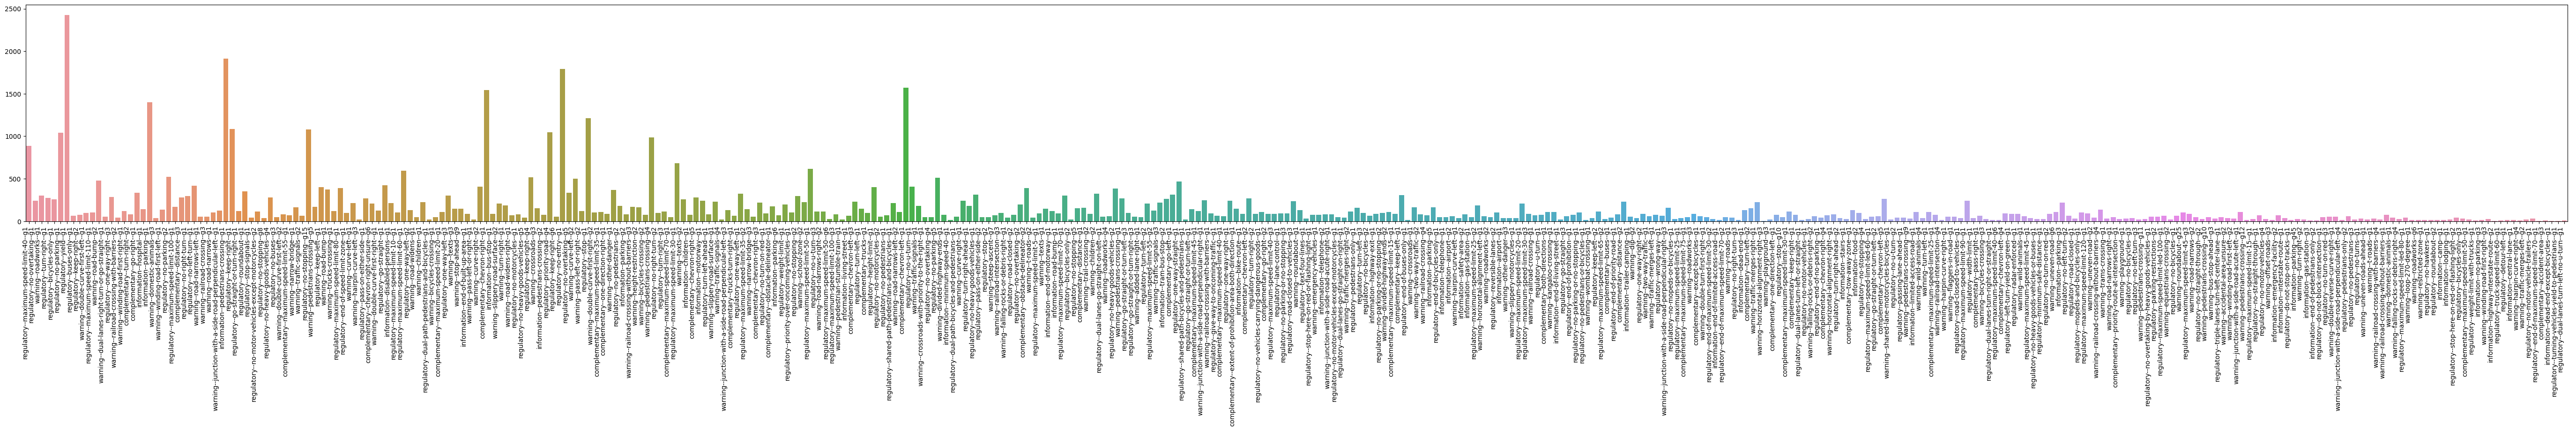

In [ ]:
# Creating a general bar chart plot showin frequency of each class ordered by index number
Names = list(Labels_with_freq.keys())
Score = list(Labels_with_freq.values())
fig, ax = plt.subplots(figsize = (70,6))
sns.barplot(x = Names,y=Score, ax= ax)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
'''
Creating smaller subplots for visual purposes for the report
'''
os.chdir("/content")
# Define the number of subplots
num_subplots = 10

# Delete the directory if it exists
if os.path.exists("subplot_images"):
  shutil.rmtree("/content/subplot_images")
# Create the directory to store the subplot images
os.mkdir("subplot_images")

# Get the names and scores from the dictionary
Names = list(Labels_with_freq.keys())
Score = list(Labels_with_freq.values())

# Calculate the number of rows needed for the subplots
num_rows = (num_subplots + 1) // 2

# Create the subplots and save each subplot as a separate image
for i in range(num_subplots):
  # Calculate the start and end indices for the sliced lists
  start = i * len(Names) // num_subplots
  end = (i + 1) * len(Names) // num_subplots
  
  # Create a bar plot for the current subplot
  fig, ax = plt.subplots(figsize=(30, 10))
  sns.barplot(x=Names[start:end], y=Score[start:end], ax=ax)
  
  # Set the x-axis tick labels to the sliced names and rotate them vertically
  ax.set_xticklabels(labels=Names[start:end], rotation='vertical',fontsize= 14)
  
  # Set the x-axis and y-axis labels for the current subplot
  ax.set_xlabel('Class Name',fontsize=14)
  ax.set_ylabel('Number of Instances',fontsize=14)
  ax.set_ylim([0, max(Score)])

  # Save the current subplot as an image
  plt.savefig(f"subplot_images/subplot_{i}.png", bbox_inches='tight')
  
  plt.close(fig)

In [ ]:
# Creating a function that compresses a directory
def zip_directory(directory_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path, os.path.relpath(file_path, directory_path))
# Compressing the subplots to be downloaded locally

zip_directory('/content/subplot_images', '/content/subplot_images.zip')

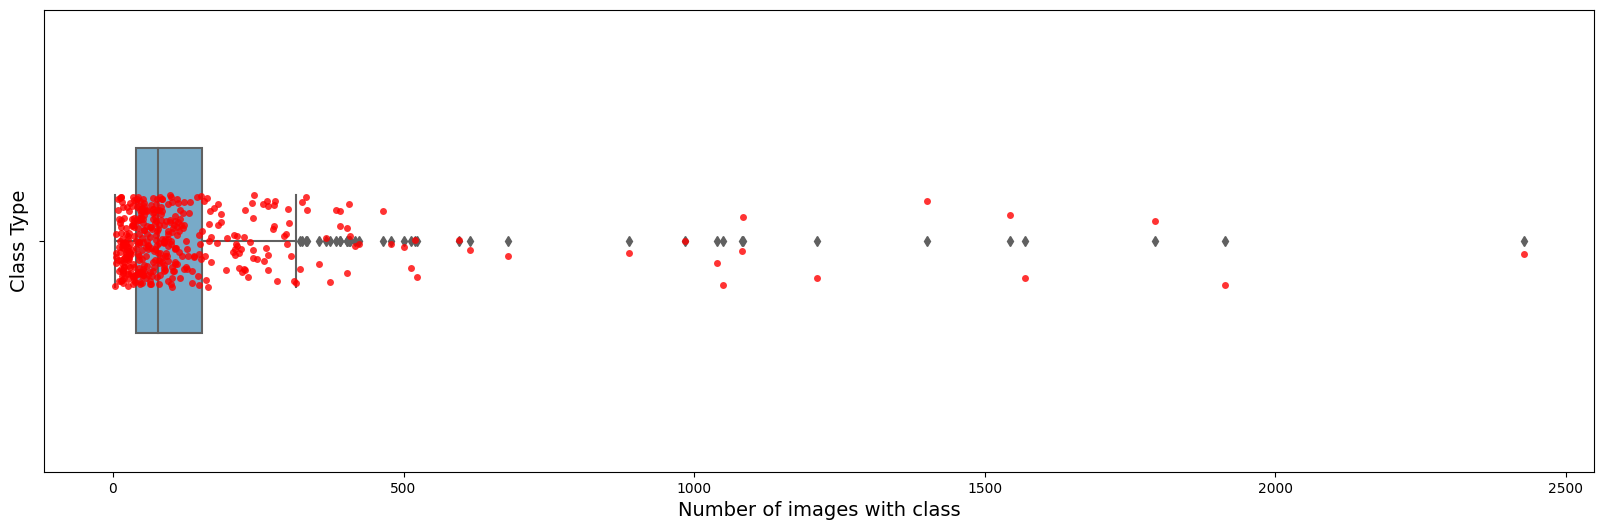

In [ ]:
# Creating boxplot to show distribution
fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(x = Score,width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
boxplot = sns.stripplot(x=Score,marker="o", alpha=0.8, color="red", s=5)
# Adding x-axis label
ax.set_xlabel('Number of images with class', fontsize=14)
# Adding y-axis label
ax.set_ylabel('Class Type', fontsize=14)
# Setting the fontsize for all text
plt.rcParams['font.size'] = 14

# 6 Converting Annotations From Mapillary Format to YOLO .txt Format (3.2)

In [ ]:
'''
Creating a function that reads the "splits" text file given in the MTSD and 
moves it to its corresponding location
'''
def move_file(text_file,final_dest):
  orginal_path = os.getcwd()
  while os.getcwd()!="/content":
    os.chdir("..")
  os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/splits")
  with open(text_file,"r") as f:
    for line in f:
      shutil.move(str("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/annotations/"+line).replace("\n","")+".json",final_dest)
move_file("val.txt","/content/drive/MyDrive/RoadSignDataset/Validation/jsonlabels")


In [ ]:
#Moving Training labels into respective folder
move_file("train.txt","/content/drive/MyDrive/RoadSignDataset/Train/jsonlabels")

In [ ]:
#Moving all remaining training labels to respective folder
while os.getcwd()!="/content":
  os.chdir("..")
os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/annotations")
for file in os.listdir():
  if ".json" in file:
    shutil.move(file, "/content/drive/MyDrive/RoadSignDataset/Train/jsonlabels")

In [ ]:
'''
Defines a function that converts MTSD annotations into YOLOv5 .txt annotations
and moves these to a separate directory
'''
while os.getcwd()!="/content":
  os.chdir("..")

def labelwrite(path_to_img,dest_path):
  os.chdir(path_to_img)
  for file in os.listdir():
    with open(file, "r") as j:
      data = json.load(j)
      w = open(str(file).replace("json","txt"), "w")
      w.write("")
      w.close
      for instance in range(0,len(data["objects"])):
        with open(str(file).replace("json","txt"),"a") as t:
          x= ((float(data["objects"][instance]["bbox"]["xmax"])+float(data["objects"][instance]["bbox"]["xmin"]))/2)/float(data["width"])
          y= ((float(data["objects"][instance]["bbox"]["ymax"])+float(data["objects"][instance]["bbox"]["ymin"]))/2)/float(data["height"])
          width= (float(data["objects"][instance]["bbox"]["xmax"])-float(data["objects"][instance]["bbox"]["xmin"]))/float(data["width"])
          height= (float(data["objects"][instance]["bbox"]["ymax"])-float(data["objects"][instance]["bbox"]["ymin"]))/float(data["height"])
          print("x="+str(x))
          t.write(str(class_list.index(data["objects"][instance]["label"]))+" "+ str(x) + " "+ str(y) + " " + str(width) + " " + str(height) +"\n")
    shutil.move(str(file).replace("json","txt"),dest_path)


In [ ]:
labelwrite("/content/drive/MyDrive/RoadSignDataset/Validation/jsonlabels","/content/drive/MyDrive/RoadSignDataset/Validation/labels")
labelwrite("/content/drive/MyDrive/RoadSignDataset/Train/jsonlabels","/content/drive/MyDrive/RoadSignDataset/Train/labels")

In [ ]:
#Checking for unlabelled validation files
os.chdir("/content/drive/MyDrive/RoadSignDataset/Validation/jsonlabels")
for entry in os.listdir():
  if ".json" in entry:
    if os.path.exists(str(entry).replace(".json",".txt"))== False:
      print(entry)

In [ ]:
#moving .txt files to correct folder for validation files
while os.getcwd()!="/content":
  os.chdir("..")
os.chdir("/content/drive/MyDrive/RoadSignDataset/Validation/jsonlabels")
for file in os.listdir():
  if ".txt" in file:
    shutil.move(file,"/content/drive/MyDrive/RoadSignDataset/Validation/labels")

In [ ]:
#moving .txt files to correct folder for training files
while os.getcwd()!="/content":
  os.chdir("..")
os.chdir("/content/drive/MyDrive/RoadSignDataset/Train/jsonlabels")
for file in os.listdir():
  if ".txt" in file:
    shutil.move(file,"/content/drive/MyDrive/RoadSignDataset/Train/labels")

In [ ]:
os.chdir("/content")

#7. Removing unnessesary classes (3.3.1)

In [ ]:
'''
Creates a list of classes to be removed by first including a list of manual 
classes chosen to be removed and then automatically appending classes 
categorised as "complementary" or "information"
'''
while os.getcwd()!="/content":
  os.chdir("..")
#Choosing selected classes to be removed
unusedclasslist = [0,3,5,7,21,28,29,32,39,44,47,57,63,67,74,75,77,80,84,85,89,91,94,102,104,105,120,124,125,126,127,128,131,132,134,138,139,140,141,142,145,146,152,160,163,162,165,166,168,169,170,174,184,185,186,187,188,189,190,191,194,195,198,200,202,205,210,215,221,222,232,237,238,250,254,255,258,259,260,269,270,274,275,277,280,281,282,285,286,287,288,292,295,296,297,301,304,305,306,308,309,310,315,316,319,322,324,325,331,334,335,336,338,341,343,342,345,348,351,352,353,355,356,358,359,360,362,364,365,367,368,369,371,372,373,374,375,377,379,380,381,383,385,386,389,390,393,395,396,398]
# Finding a list of classes without information
# or complementary classes

# Removing all information and complementary classes from labels
lineNumber = -1
Chosen_Word = "information"
Chosen_Word2= "complementary"
if os.path.exists("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/newlabelclasses.txt") ==True:
  os.remove("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/newlabelclasses.txt")
os.chdir("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN")
with open("labelclasses.txt","r") as fileData:
  for line in fileData:
    lineNumber += 1
    if Chosen_Word in line:
      unusedclasslist.append(lineNumber)
    elif Chosen_Word2 in line:
      unusedclasslist.append(lineNumber)
    elif Chosen_Word or Chosen_Word2 not in line:
      # Creating a list of new classes
      if lineNumber not in unusedclasslist:
        with open("newlabelclasses.txt","a") as new:
          new.write(line)
print(unusedclasslist)
new = []
dup = []
for i in unusedclasslist:
  if i not in new:
    new.append(i)
  else:
    dup.append(i)
unusedclasslist = new

[0, 3, 5, 7, 21, 28, 29, 32, 39, 44, 47, 57, 63, 67, 74, 75, 77, 80, 84, 85, 89, 91, 94, 102, 104, 105, 120, 124, 125, 126, 127, 128, 131, 132, 134, 138, 139, 140, 141, 142, 145, 146, 152, 160, 163, 162, 165, 166, 168, 169, 170, 174, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 198, 200, 202, 205, 210, 215, 221, 222, 232, 237, 238, 250, 254, 255, 258, 259, 260, 269, 270, 274, 275, 277, 280, 281, 282, 285, 286, 287, 288, 292, 295, 296, 297, 301, 304, 305, 306, 308, 309, 310, 315, 316, 319, 322, 324, 325, 331, 334, 335, 336, 338, 341, 343, 342, 345, 348, 351, 352, 353, 355, 356, 358, 359, 360, 362, 364, 365, 367, 368, 369, 371, 372, 373, 374, 375, 377, 379, 380, 381, 383, 385, 386, 389, 390, 393, 395, 396, 398, 10, 11, 13, 19, 24, 25, 27, 30, 31, 34, 35, 36, 40, 42, 49, 51, 53, 56, 59, 65, 68, 79, 82, 95, 99, 107, 117, 121, 126, 135, 147, 148, 151, 157, 158, 161, 162, 164, 171, 173, 176, 179, 181, 182, 192, 196, 201, 209, 214, 216, 218, 220, 226, 228, 234, 235, 239, 240, 246, 247, 2

In [ ]:
# Checks the number of classes that will be removed
len(unusedclasslist)

237

In [ ]:
# Removing all unwanted classes from training labels
os.chdir("/content/Train/labels")
# Checking how many images were removed
Original_Size = len(os.listdir())
for filename in os.listdir():
  with open(str(filename),"r") as file:
    with open("temp.txt","w") as output:
      for line in file:
        word_split = line.split()
        if int(word_split[0]) not in unusedclasslist:
          output.write(line)
  os.replace("temp.txt",str(filename))
  if os.path.getsize(str(filename)) ==0:
    os.remove(str(filename))
Updated_Size = len(os.listdir())
print("Number of files removed = {}".format(int(Original_Size-Updated_Size)))

# Removing all unwanted classes from training labels
os.chdir("/content/Validation/labels")
# Checking how many images were removed
Original_Size = len(os.listdir())
for filename in os.listdir():
  with open(str(filename),"r") as file:
    with open("temp.txt","w") as output:
      for line in file:
        word_split = line.split()
        if int(word_split[0]) not in unusedclasslist:
          output.write(line)
  os.replace("temp.txt",str(filename))
  if os.path.getsize(str(filename)) ==0:
    os.remove(str(filename))
Updated_Size = len(os.listdir())
print("Number of files removed = {}".format(int(Original_Size-Updated_Size)))

Number of files removed = 17982
Number of files removed = 2634


In [ ]:
print(len(os.listdir("/content/Train/labels")))

18607


In [ ]:
#Removing all unlabelled training images
os.chdir("/content/Train/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Train/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Train/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Train/images")

In [ ]:
#Removing all unlabelled validation images
os.chdir("/content/Validation/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Validation/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Validation/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Validation/images")

In [ ]:
print(numberofremovedimages)

2634


#8. Description after removing unnessesary classes (3.3.1)

In [ ]:
print("Number of Training Classes = {}".format(len(Num_of_Classes("/content/Train/labels"))))
print("Number of Validation Classes = {}".format(len(Num_of_Classes("/content/Validation/labels"))))

Number of Training Classes = 164
Number of Validation Classes = 162


In [ ]:
#Finding the number of instances for class

class_list = Num_of_Classes("/content/Train/labels")
class_list_final= []
for i in class_list:
  class_list_final.append(int(i))
class_list_final.sort()
line_num = -1
label_dict = {}
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt","r") as file:
  for line in file:
    if "\n" in line:
      line.replace("\n","")
    line_num +=1
    if line_num in class_list_final:
      label_dict[line_num] = line

In [ ]:
#Finding frequency of instances for each class

os.chdir("/content/Train/labels")
label_dict1 = {}
Labels_with_freq = {}
for i in os.listdir():
  with open(str(i),"r") as file:
    for line in file:
      words_split = line.split()
      if words_split[0] in label_dict1:
        label_dict1[words_split[0]] += 1
      else:
        label_dict1[words_split[0]] = 1
for key, value in label_dict1.items():
  Labels_with_freq[label_dict[int(key)]] = value


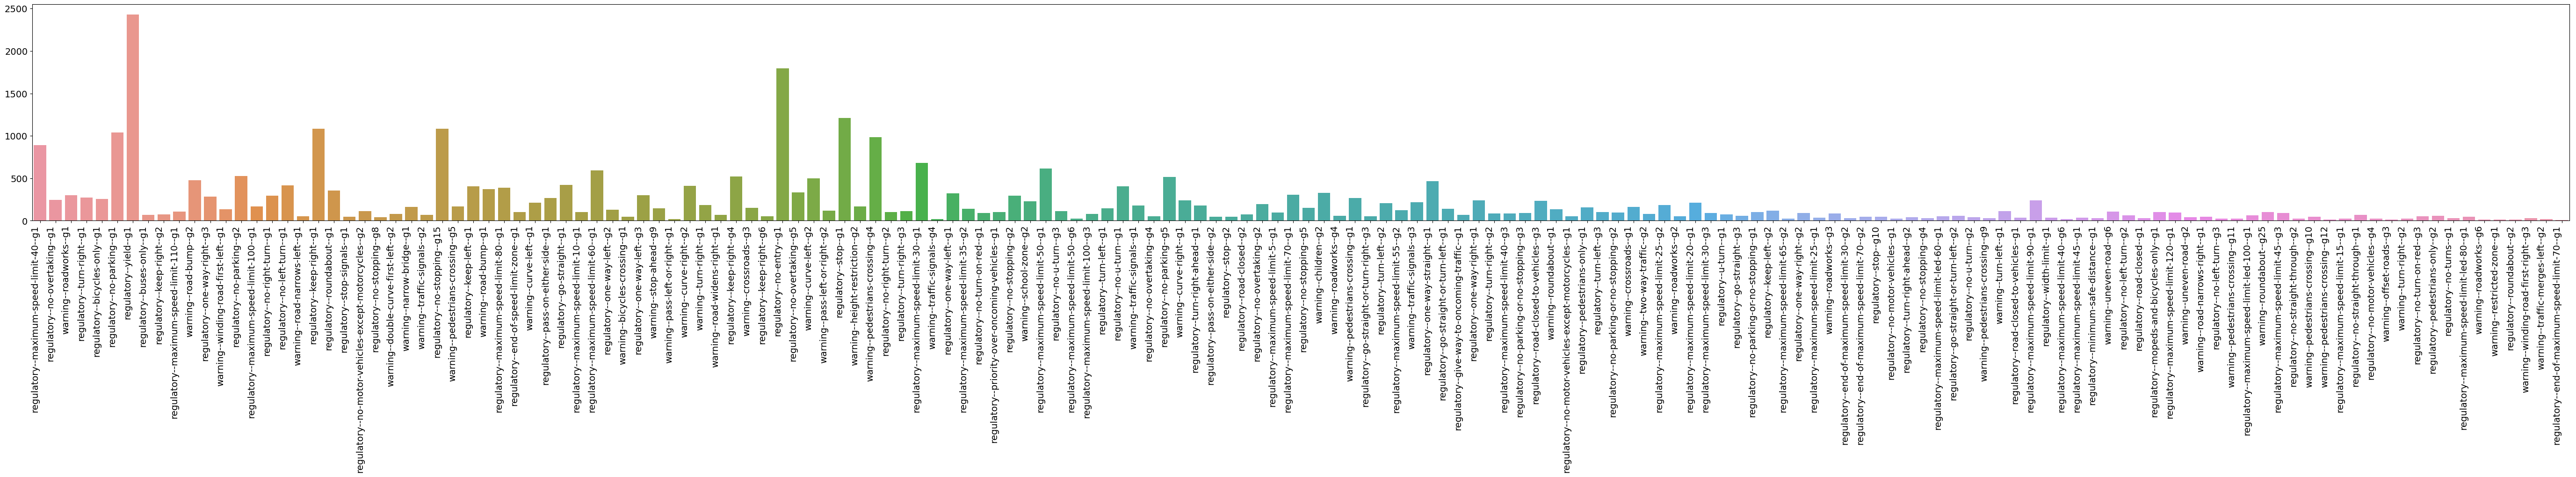

In [ ]:
'''
Plotting a general bar chart of number of instances for each class 
ordered by index number
'''
Names = list(Labels_with_freq.keys())
Score = list(Labels_with_freq.values())
fig, ax = plt.subplots(figsize = (70,6))
sns.barplot(x = Names,y=Score, ax= ax)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
'''
Creates a number of subplots for viewing the bar chart in the report
'''
os.chdir("/content")
# Define the number of subplots
num_subplots = 4

# Delete the directory if it exists
if os.path.exists("subplot_images"):
    shutil.rmtree("/content/subplot_images")
# Create the directory to store the subplot images
os.mkdir("subplot_images")

# Get the names and scores from the dictionary
Names = list(Labels_with_freq.keys())
Score = list(Labels_with_freq.values())

# Calculate the number of rows needed for the subplots
num_rows = (num_subplots + 1) // 2

# Create the subplots and save each subplot as a separate image
for i in range(num_subplots):
    # Calculate the start and end indices for the sliced lists
    start = i * len(Names) // num_subplots
    end = (i + 1) * len(Names) // num_subplots
    
    # Create a bar plot for the current subplot
    fig, ax = plt.subplots(figsize=(30, 10))
    sns.barplot(x=Names[start:end], y=Score[start:end], ax=ax)
    
    # Set the x-axis tick labels to the sliced names and rotate them vertically
    ax.set_xticklabels(labels=Names[start:end], rotation='vertical',fontsize= 14)
    
    # Set the x-axis and y-axis labels for the current subplot
    ax.set_xlabel('Class Name',fontsize=14)
    ax.set_ylabel('Number of Instances',fontsize=14)
    ax.set_ylim([0, max(Score)])

    # Save the current subplot as an image
    plt.savefig(f"subplot_images/subplot_{i}.png", bbox_inches='tight')
    
    plt.close(fig)

In [ ]:
def zip_directory(directory_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path, os.path.relpath(file_path, directory_path))
zip_directory('/content/subplot_images', '/content/subplot_images.zip')

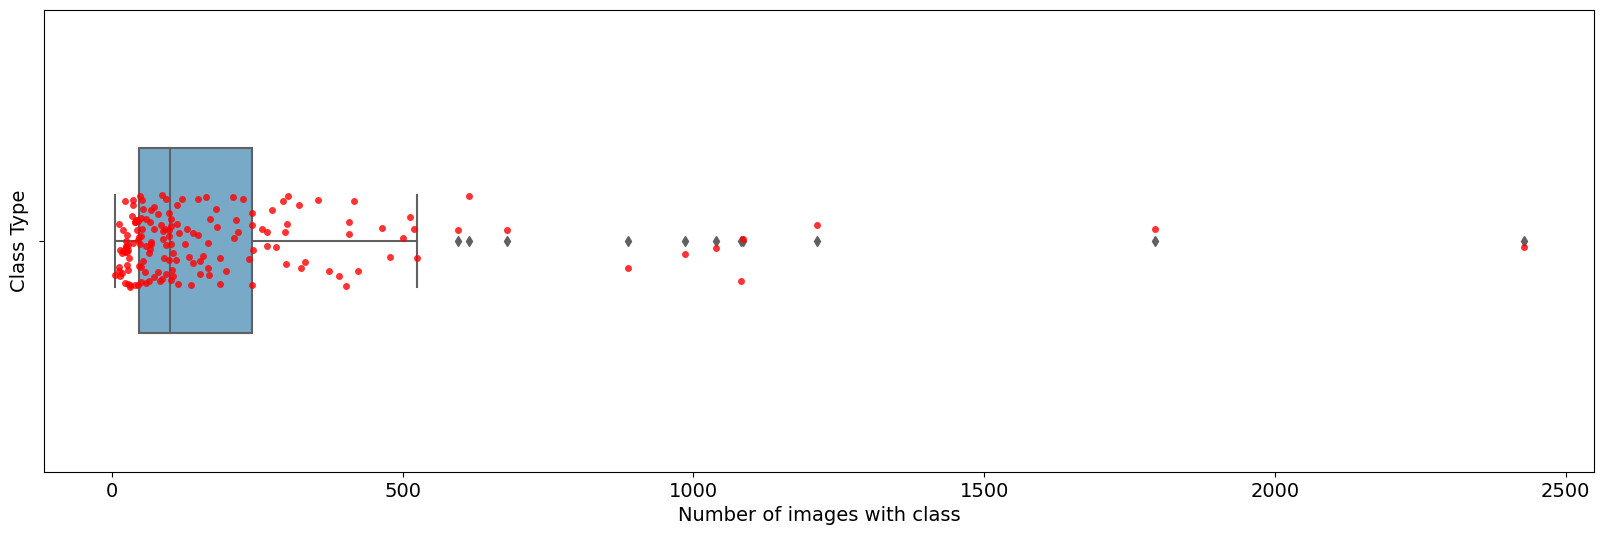

In [ ]:
# Creating boxplot
fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(x = Score,width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
boxplot = sns.stripplot(x=Score,marker="o", alpha=0.8, color="red", s=5)
# Adding x-axis label
ax.set_xlabel('Number of images with class', fontsize=14)
# Adding y-axis label
ax.set_ylabel('Class Type', fontsize=14)
# Setting the fontsize for all text
plt.rcParams['font.size'] = 14

# Further reduction of dataset for low instance classes

In [ ]:
#Creating a dictionary that maps labels used for other regions to the used region

In [ ]:
#Finding the number of classes in training labels
os.chdir("/content/Train/labels")
class_list= []
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

Number of classes = 164


In [ ]:
class_names = []
class_names1 = []
duplicates = []
Dup2Original = {}
replacing_values = {}
name_key_dict = {}
#Finding the number of instances for class
class_list_final = []
for i in class_list:
  class_list_final.append(int(i))
class_list_final.sort()
line_num = -1
name_key_dict = {}
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt","r") as file:
  for line in file:
    if "\n" in line:
      line =line.replace("\n","")
    line_num +=1
    if line_num in class_list_final:
      name_key_dict[line_num] = line
for key, value in name_key_dict.items():
  value_split = str(value).replace("\n","").split("--")
  if str(value_split[0]+" "+ value_split[1]) not in class_names:
    class_names.append(value_split[0]+" "+ value_split[1])
    class_names1.append(str(value_split[0]+"--"+value_split[1]+"--"+value_split[2]))
  else:
    duplicates.append(str(value_split[0]+"--"+value_split[1]+"--"+value_split[2]))

for i in duplicates:
  for j in class_names1:
    word_split = str(j).replace("\n","").split("--")
    dup_split = i.split("--")
    if word_split[0]+ word_split[1] == dup_split[0]+dup_split[1]:
      Dup2Original[list(name_key_dict.keys())[list(name_key_dict.values()).index(i)]] = list(name_key_dict.keys())[list(name_key_dict.values()).index(j)]
    

In [ ]:
name_key_dict[172]

'regulatory--maximum-speed-limit-55--g2'

In [ ]:
os.chdir("/content/Train/labels")
for i in os.listdir():
  with open(i,"r") as text_file:
    with open("temp.txt", "w") as temp:
      for line in text_file:
        word_split = line.split()
        if int(word_split[0]) in list(Dup2Original.keys()):
          temp.write(line.replace(word_split[0],str(Dup2Original[int(word_split[0])])))
        else:
          temp.write(line)
  os.remove(i)
  os.rename("temp.txt",i)

os.chdir("/content/Validation/labels")
for i in os.listdir():
  with open(i,"r") as text_file:
    with open("temp.txt", "w") as temp:
      for line in text_file:
        word_split = line.split()
        if int(word_split[0]) in list(Dup2Original.keys()):
          temp.write(line.replace(word_split[0],str(Dup2Original[int(word_split[0])])))
        else:
          temp.write(line)
  os.remove(i)
  os.rename("temp.txt",i)


In [ ]:
#Finding the number of classes in training labels
os.chdir("/content/Train/labels")
class_list= []
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

Number of classes = 93


In [ ]:
#Finding the number of classes in validation labels
os.chdir("/content/Validation/labels")
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

Number of classes = 93


In [ ]:
#Finding the number of instances for class
class_list_final = []
for i in class_list:
  class_list_final.append(int(i))
class_list_final.sort()
line_num = -1
name_key_dict = {}
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt","r") as file:
  for line in file:
    if "\n" in line:
      line =line.replace("\n","")
    line_num +=1
    if line_num in class_list_final:
      name_key_dict[line_num] = line

In [ ]:
#Finding frequency
os.chdir("/content/Train/labels")
label_dict1 = {}
Labels_with_freq = {}
for i in os.listdir():
  with open(str(i),"r") as file:
    for line in file:
      words_split = line.split()
      if words_split[0] in label_dict1:
        label_dict1[words_split[0]] += 1
      else:
        label_dict1[words_split[0]] = 1
for key, value in label_dict1.items():
  Labels_with_freq[name_key_dict[int(key)]] = value

In [ ]:
#removing classes with frequency lower than 150
min_freq = 150
for i in Labels_with_freq.keys():
  if Labels_with_freq[i] <=min_freq:
    unusedclasslist.append(list(name_key_dict.values()).index(i))
# Removing all unwanted classes from training labels
os.chdir("/content/Train/labels")
# Checking how many images were removed
Original_Size = len(os.listdir())
for filename in os.listdir():
  with open(str(filename),"r") as file:
    with open("temp.txt","w") as output:
      for line in file:
        word_split = line.split()
        if int(word_split[0]) not in unusedclasslist:
          output.write(line)
  os.replace("temp.txt",str(filename))
  if os.path.getsize(str(filename)) ==0:
    os.remove(str(filename))
Updated_Size = len(os.listdir())
print("Number of files removed = {}".format(int(Original_Size-Updated_Size)))

# Removing all unwanted classes from Validation labels
os.chdir("/content/Validation/labels")
# Checking how many images were removed
Original_Size = len(os.listdir())
for filename in os.listdir():
  with open(str(filename),"r") as file:
    with open("temp.txt","w") as output:
      for line in file:
        word_split = line.split()
        if int(word_split[0]) not in unusedclasslist:
          output.write(line)
  os.replace("temp.txt",str(filename))
  if os.path.getsize(str(filename)) ==0:
    os.remove(str(filename))
Updated_Size = len(os.listdir())
print("Number of files removed = {}".format(int(Original_Size-Updated_Size)))


Number of files removed = 4449
Number of files removed = 664


In [ ]:
#Finding the number of classes in training labels
os.chdir("/content/Train/labels")
class_list= []
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

Number of classes = 75


In [ ]:
#Removing all unlabelled validation images
os.chdir("/content/Validation/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Validation/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Validation/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Validation/images")

In [ ]:
#Removing all unlabelled training images
os.chdir("/content/Train/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Train/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Train/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Train/images")
print(numberofremovedimages)

4449


In [ ]:
print(len(os.listdir("/content/Train/images"))-len(os.listdir("/content/Train/labels")))
print(len(os.listdir("/content/Validation/images"))-len(os.listdir("/content/Validation/labels")))

0
0


# 9. Grouping regional labels (3.3.2)

In [ ]:
#Creating a dictionary that maps labels used for other regions to the used region

In [ ]:
#Finding the number of classes in training labels
os.chdir("/content/Train/labels")
class_list= []
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

In [ ]:
class_names = []
class_names1 = []
duplicates = []
Dup2Original = {}
replacing_values = {}
name_key_dict = {}
#Finding the number of instances for class
class_list_final = []
for i in class_list:
  class_list_final.append(int(i))
class_list_final.sort()
line_num = -1
name_key_dict = {}
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt","r") as file:
  for line in file:
    if "\n" in line:
      line =line.replace("\n","")
    line_num +=1
    if line_num in class_list_final:
      name_key_dict[line_num] = line
for key, value in name_key_dict.items():
  value_split = str(value).replace("\n","").split("--")
  if str(value_split[0]+" "+ value_split[1]) not in class_names:
    class_names.append(value_split[0]+" "+ value_split[1])
    class_names1.append(str(value_split[0]+"--"+value_split[1]+"--"+value_split[2]))
  else:
    duplicates.append(str(value_split[0]+"--"+value_split[1]+"--"+value_split[2]))

for i in duplicates:
  for j in class_names1:
    word_split = str(j).replace("\n","").split("--")
    dup_split = i.split("--")
    if word_split[0]+ word_split[1] == dup_split[0]+dup_split[1]:
      Dup2Original[list(name_key_dict.keys())[list(name_key_dict.values()).index(i)]] = list(name_key_dict.keys())[list(name_key_dict.values()).index(j)]
    

In [ ]:
name_key_dict[172]

In [ ]:
os.chdir("/content/Train/labels")
for i in os.listdir():
  with open(i,"r") as text_file:
    with open("temp.txt", "w") as temp:
      for line in text_file:
        word_split = line.split()
        if int(word_split[0]) in list(Dup2Original.keys()):
          temp.write(line.replace(word_split[0],str(Dup2Original[int(word_split[0])])))
        else:
          temp.write(line)
  os.remove(i)
  os.rename("temp.txt",i)

os.chdir("/content/Validation/labels")
for i in os.listdir():
  with open(i,"r") as text_file:
    with open("temp.txt", "w") as temp:
      for line in text_file:
        word_split = line.split()
        if int(word_split[0]) in list(Dup2Original.keys()):
          temp.write(line.replace(word_split[0],str(Dup2Original[int(word_split[0])])))
        else:
          temp.write(line)
  os.remove(i)
  os.rename("temp.txt",i)


In [ ]:
#Finding the number of classes in training labels
os.chdir("/content/Train/labels")
class_list= []
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

In [ ]:
#Finding the number of classes in validation labels
os.chdir("/content/Validation/labels")
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

In [ ]:
#Finding frequency
os.chdir("/content/Train/labels")
label_dict1 = {}
Labels_with_freq = {}
for i in os.listdir():
  with open(str(i),"r") as file:
    for line in file:
      words_split = line.split()
      if words_split[0] in label_dict1:
        label_dict1[words_split[0]] += 1
      else:
        label_dict1[words_split[0]] = 1
for key, value in label_dict1.items():
  Labels_with_freq[label_dict[int(key)]] = value


In [ ]:
len(Labels_with_freq)

In [ ]:
# Creating boxplot
fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(x = Score,width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
boxplot = sns.stripplot(x=Score,marker="o", alpha=0.8, color="red", s=5)
# Adding x-axis label
ax.set_xlabel('Number of images with class', fontsize=16)
# Adding y-axis label
ax.set_ylabel('Class Type', fontsize=16)
# Setting the fontsize for all text
plt.rcParams['font.size'] = 16

# 10. Removing Low instance Classes (3.3.3)

In [ ]:
#Finding the number of instances for class
class_list_final = []
for i in class_list:
  class_list_final.append(int(i))
class_list_final.sort()
line_num = -1
name_key_dict = {}
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt","r") as file:
  for line in file:
    if "\n" in line:
      line =line.replace("\n","")
    line_num +=1
    if line_num in class_list_final:
      name_key_dict[line_num] = line

In [ ]:
#Finding frequency
os.chdir("/content/Train/labels")
class_with_freq = {}
Labels_with_freq = {}
for i in os.listdir():
  with open(str(i),"r") as file:
    for line in file:
      words_split = line.split()
      if words_split[0] in class_with_freq:
        class_with_freq[words_split[0]] += 1
      else:
        class_with_freq[words_split[0]] = 1
for key, value in class_with_freq.items():
  Labels_with_freq[name_key_dict[int(key)]] = value

In [ ]:
#removing classes with frequency lower than 150
min_freq = 100

# Removing all unwanted classes from training labels
os.chdir("/content/Train/labels")
# Checking how many images were removed
Original_Size = len(os.listdir())
for key, value in class_with_freq.items():
  # If the value (frequency) is less than the minimum frequency, remove all files containing that class
  if value < min_freq:
  # Iterate over all files in the data directory
    for file in os.listdir():
      # Check if the file is a text file
      if file.endswith(".txt"):
        # Open the file and read its contents
        with open(file, "r") as f:
          contents = f.readlines()
        # Filter out any lines containing the class to be removed
        contents = [line for line in contents if line.split()[0] != key]
        # Overwrite the file with the filtered contents
        with open(file, "w") as f:
          f.writelines(contents)
        # Check if the file is empty
        if os.stat(file).st_size == 0:
          # Delete the file if it is empty
          os.remove(file)

In [ ]:
#Finding frequency
os.chdir("/content/Train/labels")
class_with_freq = {}
Labels_with_freq = {}
for i in os.listdir():
  with open(str(i),"r") as file:
    for line in file:
      words_split = line.split()
      if words_split[0] in class_with_freq:
        class_with_freq[words_split[0]] += 1
      else:
        class_with_freq[words_split[0]] = 1
for key, value in class_with_freq.items():
  Labels_with_freq[name_key_dict[int(key)]] = value

In [ ]:
len(Labels_with_freq)

In [ ]:
# Creates a generalised boxplot showing the final distribution
Names = list(Labels_with_freq.keys())
Score = list(Labels_with_freq.values())
fig, ax = plt.subplots(figsize = (70,6))
sns.barplot(x = Names,y=Score, ax= ax)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#Finding the number of classes in training labels
os.chdir("/content/Train/labels")
class_list= []
for file in os.listdir():
  with open(str(file),"r") as text_file:
    for line in text_file:
      word_split = line.split()
      if word_split[0] not in class_list:
        class_list.append(word_split[0])
print("Number of classes = {}".format(len(class_list)))

In [ ]:
#Removing all unlabelled validation images
os.chdir("/content/Validation/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Validation/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Validation/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Validation/images")
print(numberofremovedimages)

In [ ]:
#Removing all unlabelled training images
os.chdir("/content/Train/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Train/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Train/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Train/images")
print(numberofremovedimages)

In [ ]:
print(len(os.listdir("/content/Train/images"))-len(os.listdir("/content/Train/labels")))
print(len(os.listdir("/content/Validation/images"))-len(os.listdir("/content/Validation/labels")))

# 11. Image Processing (3.4)

In [ ]:
'''
Defining a fucntion that can be used to describe the properties of images in
the dataset
'''
def get_img_size(path_to_imgdirectory):
  original_path = os.getcwd()
  os.chdir(path_to_imgdirectory)
  '''
  0 = height
  1 = width
  2 = Area
  3 = Channel
  '''
  height = []
  width = []
  Area = []
  for i in os.listdir():
    if ".jpg" in i:
      dimension_list = []
      image = cv2.imread(i)
      h,w,c = image.shape
      height.append(h)
      width.append(w)
      Area.append(h*w)
  return height,width,Area
  os.chdir(original_path)

In [ ]:
train_height,train_width,train_Area = get_img_size("/content/Train/images")

In [ ]:
'''
Gives a description of the properties of images within the dataset including
standard deviation, average sizes and then creates a boxplot to visualise the 
distribution better
'''
#Finding size for scaling:
quantile_num = 0.5
print("Average image height: {}".format(np.average(train_height)))
print("Average image width: {}".format(np.average(train_width)))
print("Standard Deviation of image width: {}".format(np.std(train_width)))
print("Standard Deviation of image height: {}".format(np.std(train_height)))
print("Standard Deviation of image area: {}".format(np.std(train_Area)))
X = train_height
Y = train_width
columns = ["Height","Width"]
# Creating Boxplot of Height and Width

# Creating a pandas dataframe to allow multiple boxplots on one figure
df = pd.DataFrame(list(zip(X,Y)),columns = columns)

fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(data = df, width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
# boxplot = sns.stripplot(data= df, marker="o", alpha=0.1, color="red", s=5)

In [ ]:
'''
Creates a function for generalised cropping by taking the path to the image
and the cropping percentage
'''
def gen_crop_img(path_img,percentage):
  original_path = os.getcwd()
  im = Image.open(path_img)
  w,h =im.size
  w1 = w*(percentage)
  h1 = h*(percentage)
  im1 = im.crop((w1,h1,w,h))
  os.chdir("/content")
  im1 = im1.save("test.jpg")
  os.chdir(original_path)

In [ ]:
gen_crop_img("/content/Validation/images/-dBtqhsBO346niG5o1CXBQ.jpg",0.4)

In [ ]:
'''
Creates a function that crops an image based on the location of its labels
but taking the path to the image and the corresponding .txt label file. This
function works with the YOLO annotation format (not the MTSD annotations)
'''
def label_crop_img(path,path_img,path_label):
  # Saving original working directory and changing working directory to image
  # path specified
  original_path = os.getcwd()
  os.chdir(path)
  # Iterates through each image in path

  # defining variables
  class_num =[]
  x_central = []
  y_central = []
  overall_width = []
  overall_height = []
  numberoflines = 0
  # Prints each iteration number
  # Setting initial bounds for cropping box co-ordinates
  # (x1,y1 must be minimised and x2,y2 must be maximised)
  y1 = 999999
  y2 = 0
  x1 = 999999
  x2 = 0
  # Opens image using PIL.Image to read image size
  im = Image.open(path_img)
  w,h = im.size
  os.chdir(path.replace("images","labels"))
  # Reads the associated text file to find label dimensions
  with open(path_label, "r") as file:
    # Iterates through each line of label .txt file
    for line in file:
      numberoflines +=1
      word_split = line.split()
      # defines temporary variables of bounding box that store individual 
      # label's dimensions on the image in pixel number (labels must be 
      # converted from percentages)
      y1_temp = h*(float(word_split[2])-float(word_split[4])/2)
      y2_temp = h*(float(word_split[2])+float(word_split[4])/2)
      x1_temp = w*(float(word_split[1])-float(word_split[3])/2)
      x2_temp = w*(float(word_split[1])+float(word_split[3])/2)
      # Checks if temporary co-ordinates are the minimum/maximum coordinates
      # of the image and if so, uses them as the cropping box dimensions
      if y1_temp <y1:
        y1 = y1_temp
      if x1_temp <x1:
        x1 = x1_temp
      if y2_temp >y2:
        y2 = y2_temp
      if x2_temp >x2:
        x2 = x2_temp
# Crops the image according to cropping box's two diagonal co-ordinates
  im1 = im.crop((x1,y1,x2,y2))
  # Deletes original label image and replaces with temporary text file
  os.chdir("/content")
  # Saves cropped image as original name
  img1 = im1.save("test_label_crop.jpg")
  # Changes working directory to working directory used when calling function
  os.chdir(original_path)
  

In [ ]:
label_crop_img("/content/Validation/images","-dBtqhsBO346niG5o1CXBQ.jpg","-dBtqhsBO346niG5o1CXBQ.txt")

In [ ]:
'''
Defining a function that takes the path to images and:

-- Iterates through each image to find its total height, width
-- Maps the image name to associated text file in respective labels directory
-- Finds the dimensions of the bounding boxes of labels in image
-- Uses the maximum bounding box dimensions as a reference for cropping image
-- Adds a 50 pixel tolerance to cropping box
-- Checks if the cropping box's dimensions are less than 1/5 of the overall 
   dimensions of the original image
    --if the cropping area is too small, adds 1/5 of the orginal image to the 
      box's dimensions
-- Crops the image to cropping box's area (using top-left and bottom-right
   co-ordinates to draw the rectanglular box)
-- Creates a new text file for new label location and deletes original
'''
def crop_img(path_img):
  # Saving original working directory and changing working directory to image
  # path specified
  original_path = os.getcwd()
  os.chdir(path_img)
  number = 0
  # Iterates through each image in path
  for i in os.listdir(path_img):
    # defining variables
    number +=1
    class_num =[]
    x_central = []
    y_central = []
    overall_width = []
    overall_height = []
    numberoflines = 0
    # Prints each iteration number
    print(i)
    # Setting initial bounds for cropping box co-ordinates
    # (x1,y1 must be minimised and x2,y2 must be maximised)
    y1 = 999999
    y2 = 0
    x1 = 999999
    x2 = 0
    if ".jpg" in i:
      # Opens image using PIL.Image to read image size
      im = Image.open(i)
      w,h = im.size
      os.chdir(path_img.replace("images","labels"))
      # Reads the associated text file to find label dimensions
      with open(i.replace(".jpg",".txt"), "r") as file:
        # Iterates through each line of label .txt file
        for line in file:
          numberoflines +=1
          word_split = line.split()
          # defines temporary variables of bounding box that store individual 
          # label's dimensions on the image in pixel number (labels must be 
          # converted from percentages)
          y1_temp = h*(float(word_split[2])-float(word_split[4])/2)
          y2_temp = h*(float(word_split[2])+float(word_split[4])/2)
          x1_temp = w*(float(word_split[1])-float(word_split[3])/2)
          x2_temp = w*(float(word_split[1])+float(word_split[3])/2)
          # Converts the central co-ordinates, width, height and class number of 
          # each label of pan image into pixel number and stores these in a list
          x_central.append(float(w* float(word_split[1])))
          y_central.append(float( h* float(word_split[2])))
          overall_width.append(float( w* float(word_split[3])))
          overall_height.append(float( h* float(word_split[4])))
          class_num.append(word_split[0])
          # Checks if temporary co-ordinates are the minimum/maximum coordinates
          # of the image and if so, uses them as the cropping box dimensions
          if y1_temp <y1:
            y1 = y1_temp
          if x1_temp <x1:
            x1 = x1_temp
          if y2_temp >y2:
            y2 = y2_temp
          if x2_temp >x2:
            x2 = x2_temp
          # Adds 50 pixels to cropping box's dimensions, making sure that the
          # box's dimensions do not go beyond the original image's dimensions
          if x1 - 50 > 0:
            x1 += -50
          if y1 - 50 > 0:
            y1 += -50
          if x2 + 50 < w:
            x2 += 50
          if y2 + 50 < w:
            y2 += 50
          # Checks if the cropping box is smaller than 1/5 of the original
          # image's dimensions and if so, adds 1/5 of the original image's
          # dimensions to image
          if x2-x1 < w/5:
            if x1 - w/5 <0:
              x2 += w/5
            else:
              x1 += -w/5
          if y2 - y1 <h/5:
            if y1 - h/5 <0:
              y2 += h/5
            else:
              y1 += -w/5
    # Crops the image according to cropping box's two diagonal co-ordinates
    im1 = im.crop((x1,y1,x2,y2))
    # Finds the new image size
    w1,h1 = im1.size
    # Creates a temporary text file to write new labels
    w = open("temp.txt", "w")
    w.write("")
    w.close
    with open("temp.txt","a") as file1:
      for j in range(0,numberoflines):
        # Writes new labels in % of image size using previous lists 
        # defined earlier
        file1.write(str(class_num[j])+" "+str((x_central[j]-x1)/w1)+" "+
                    str((y_central[j]-y1)/h1)+" "+str(overall_width[j]/w1)+" "+
                    str(overall_height[j]/h1)+"\n")
    # Deletes original label image and replaces with temporary text file
    os.remove(str(i.replace(".jpg",".txt")))
    os.rename("temp.txt",i.replace(".jpg",".txt"))
    os.chdir(path_img)
    # Saves cropped image as original name
    img1 = im1.save(i)
  # Changes working directory to working directory used when calling function
  os.chdir(original_path)
    

In [ ]:
crop_img("/content/Validation/images")

In [ ]:
crop_img("/content/Train/images")

In [ ]:
train_crop_height,train_crop_width,train_crop_Area = get_img_size("/content/Train/images")

In [ ]:
'''
Describing the new properties of images in the dataset.
This is also used to find the 20% quantile of the average 
height and width, later used for image resizing during training.
'''
quantile_num = 0.2
print(str(quantile_num) + " quantile of image height: {}".format(np.quantile(train_crop_height, quantile_num)))
print(str(quantile_num) +" quantile of image width: {}".format(np.quantile(train_crop_width, quantile_num)))
print("Standard Deviation of image width: {}".format(np.std(train_crop_width)))
print("Standard Deviation of image height: {}".format(np.std(train_crop_height)))
print("Standard Deviation of image area: {}".format(np.std(train_crop_Area)))
X = train_crop_height
Y = train_crop_width
columns = ["Height","Width"]
# Creating Boxplot of Height and Width

# Creating a pandas dataframe to allow multiple boxplots on one figure
df = pd.DataFrame(list(zip(X,Y)),columns = columns)

fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(data = df, width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
# boxplot = sns.stripplot(data= df, marker="o", alpha=0.1, color="red", s=5)

In [ ]:
'''
checks if images in the dataset have very small annotations and prints their
name
'''
number =0
num = 0
# Set the path to the directory containing the label files
label_dir = '/content/Validation/labels'

for filename in os.listdir(label_dir):
  if filename.endswith('.txt'):
    # Open the label file and read its contents
    with open(os.path.join(label_dir, filename), 'r') as f:
      contents = f.readlines()

    # Open the corresponding image and get its dimensions
    img_path = os.path.join(label_dir.replace("labels","images"), os.path.splitext(filename)[0] + '.jpg')
    with Image.open(img_path) as img:
      img_width, img_height = img.size
    
    # Loop over each line in the label file
    for line in contents:
      # Parse the line to extract the label and its coordinates
      label, x_center, y_center, width, height = line.strip().split()
      x_min = (float(x_center) - float(width) / 2) * img_width
      y_min = (float(y_center) - float(height) / 2) * img_height
      x_max = (float(x_center) + float(width) / 2) * img_width
      y_max = (float(y_center) + float(height) / 2) * img_height

      # Check if the width of the label is less than 3 pixels
      if (x_max - x_min) < 10:
        print(f"{filename}: {label} has a width of less than 3 pixels")

7LzlFAg0U7HODtmfbBeQbw.txt: 20 has a width of less than 3 pixels
_YsJ3vVlMPSXiNz0zryuXA.txt: 20 has a width of less than 3 pixels
3yshc8MVRx_whI9kguNoaw.txt: 26 has a width of less than 3 pixels
_DlwPa2m8WcpEvVW7U416g.txt: 20 has a width of less than 3 pixels
RKS5rIpBCL-sYOvhWSM29A.txt: 20 has a width of less than 3 pixels
5ZmsfxIrMa6TmjFE0i-HhA.txt: 103 has a width of less than 3 pixels
c3ndjD6bIqSaIGl9Ga1CMA.txt: 98 has a width of less than 3 pixels
u8x_AdYs_a_MvNZru0mVeA.txt: 20 has a width of less than 3 pixels
LUHloxkD12IrZ0deFe-YLQ.txt: 20 has a width of less than 3 pixels
LUHloxkD12IrZ0deFe-YLQ.txt: 20 has a width of less than 3 pixels
HmQSE0XITcxRrbVaKj08Rw.txt: 20 has a width of less than 3 pixels
S5NEaNj14lYGRRRarwJQLg.txt: 113 has a width of less than 3 pixels


# 12. Background elmination method (3.5)

In [43]:
'''
Creates  background elimination function that takes the image path.
The function first defines image thresholds, including an inverse threshold for
green colours associated with grass and trees.
The function then creates colour masks for the image based and these thresholds
and combines them into one image. The image is then saved and replaces the 
original image in the dataset
'''
def isolate_traffic_signs(image_path):
  # Read the image
  image = cv2.imread(image_path)
  # Convert the image to the HSV color space
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define improved color ranges for red, blue, yellow, black, and white traffic signs
  lower_red1 = np.array([0, 70, 50])
  upper_red1 = np.array([12, 255, 255])
  lower_red2 = np.array([155, 70, 50])
  upper_red2 = np.array([180, 255, 255])
  lower_blue = np.array([95, 150, 50])  # Adjusted blue range to further exclude sky colors
  upper_blue = np.array([145, 255, 255])
  lower_yellow = np.array([35, 100, 100])  # Adjusted yellow range to exclude green colors
  upper_yellow = np.array([45, 255, 255])
  lower_black = np.array([0, 0, 0])
  upper_black = np.array([180, 255, 100])
  lower_white = np.array([0, 0, 200])  # Adjusted white range to further exclude clouds
  upper_white = np.array([180, 40, 255])
  trees_lower = np.array([0, 60, 0], dtype=np.uint8)
  trees_upper = np.array([50, 255, 50], dtype=np.uint8)
  grass_lower = np.array([0, 120, 0], dtype=np.uint8)
  grass_upper = np.array([100, 255, 100], dtype=np.uint8)
  # Threshold the image for each color range
  mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
  mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
  mask_red = cv2.bitwise_or(mask_red1, mask_red2)
  mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
  mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
  mask_black = cv2.inRange(hsv, lower_black, upper_black)
  mask_white = cv2.inRange(hsv, lower_white, upper_white)
  trees_mask = cv2.inRange(hsv, trees_lower, trees_upper)
  grass_mask = cv2.inRange(hsv, grass_lower, grass_upper)

  # Combine the masks for all color ranges
  mask_combined = cv2.bitwise_or(mask_red, mask_blue)
  mask_combined = cv2.bitwise_or(mask_combined, mask_yellow)
  mask_combined = cv2.bitwise_or(mask_combined, mask_black)
  mask_combined = cv2.bitwise_or(mask_combined, mask_white)
  mask_combined = cv2.bitwise_or(mask_combined, mask_white)
  # Invert the green mask
  mask_trees_grass = cv2.bitwise_or(trees_mask, grass_mask)
  mask_trees_grass_inv = cv2.bitwise_not(mask_trees_grass)
  mask_combined = cv2.bitwise_and(mask_combined, mask_trees_grass_inv)
  # Erosion
  kernel = np.ones((3, 3), np.uint8)
  mask_combined = cv2.erode(mask_combined, kernel, iterations=1)

  # Dilation
  mask_combined = cv2.dilate(mask_combined, kernel, iterations=1)

  # Gaussian blurring
  mask_combined = cv2.GaussianBlur(mask_combined, (5, 5), 0)

  # Apply the mask to the original image
  result = cv2.bitwise_and(image, image, mask=mask_combined)

  # Overwrite the original image
  cv2.imwrite(image_path, result)
  print()

In [ ]:
# Applying background elimination for the training folder
os.chdir("/content/Train/images")
number =0
for file in os.listdir():
  number += 1
  isolate_traffic_signs(file)
  print(str(number)+"/"+str(len(os.listdir())))

In [ ]:
# Applying background elimination for the validation
os.chdir("/content/Validation/images")
number =0
for file in os.listdir():
  number += 1
  isolate_traffic_signs(file)
  print(str(number)+"/"+str(len(os.listdir())))

In [46]:
# Preparing for compressing background eliminated images, used to reduce
# time taken to load dataset for training
os.chdir("/content")
os.mkdir("bkzipped")
shutil.move("/content/Validation","/content/bkzipped/Validation")
shutil.move("/content/Train","/content/bkzipped/Train")

'/content/bkzipped/Train'

In [47]:
def zip_directory(directory_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path, os.path.relpath(file_path, directory_path))

In [48]:
zip_directory("/content/bkzipped","/content/drive/MyDrive/RoadSignDataset/Workspace/bkzipped.zip")

# 13. Final Dataset Attributes (3.5)

In [ ]:
#Finds the number of classes in the dataset
len(Labels_with_freq)

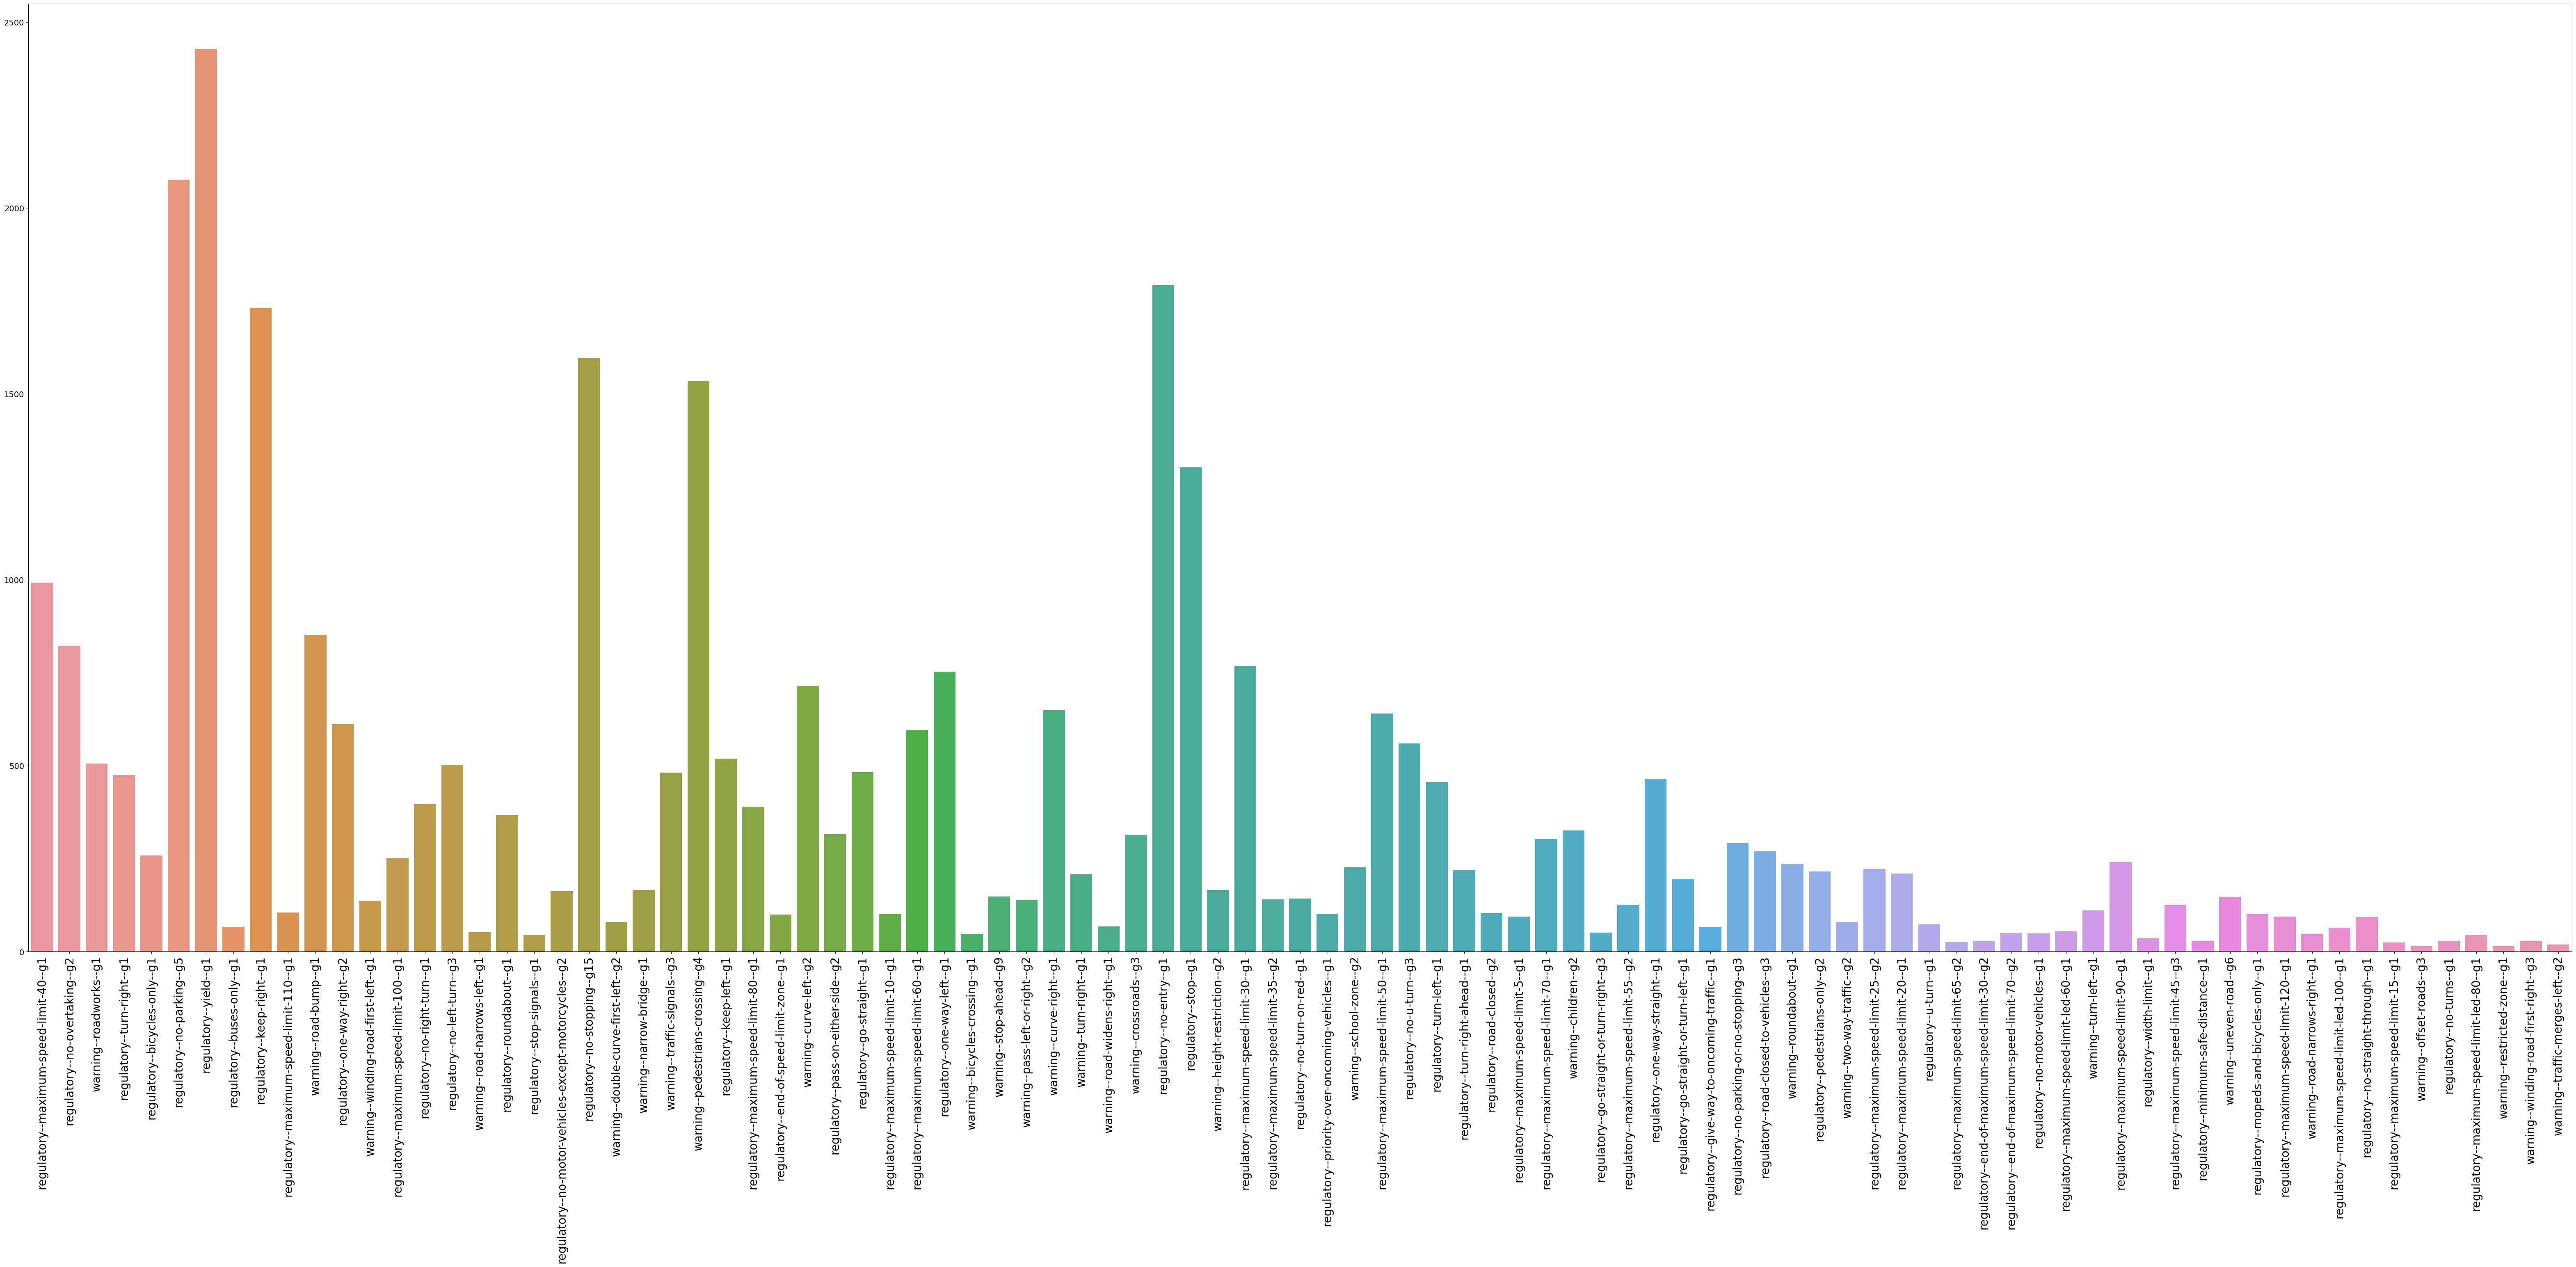

In [ ]:
#Creates a general bar chart
Names = list(Labels_with_freq.keys())
Score = list(Labels_with_freq.values())
fig, ax = plt.subplots(figsize = (80,30))
sns.barplot(x = Names,y=Score, ax= ax)
plt.xticks(rotation='vertical', size = 20)
plt.show()

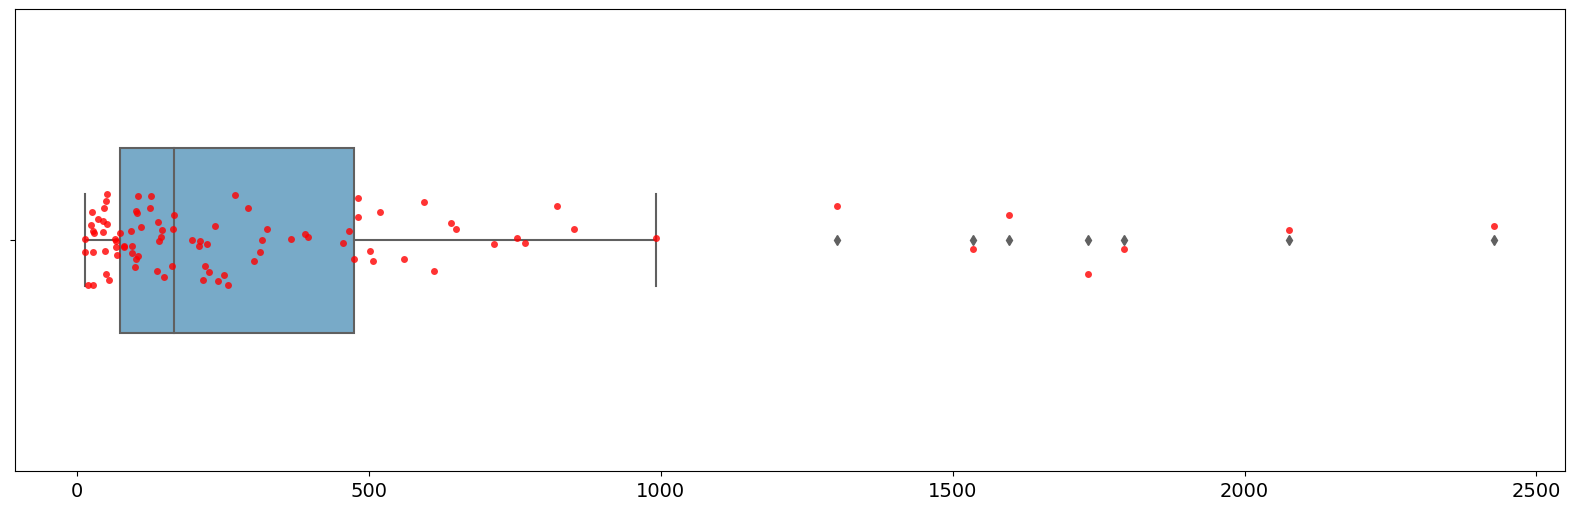

In [ ]:
# Creating boxplot to describe the distribution of class numbers in the image
fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(x = Score,width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
boxplot = sns.stripplot(x=Score,marker="o", alpha=0.8, color="red", s=5)

# 14. Creating Yaml files for YOLO (3.6)

In [6]:
#Defining Training Data
while os.getcwd()!="/content":
  os.chdir("..")
if os.path.exists("/content/drive/MyDrive/yolov5/data/custom1.yaml") == False:
  data = dict(
      names = class_list,
      nc = len(class_list),
      val = "Validation/images",
      test = "Test",
      train = "Train/images",
      path = "/content",
  )
  with open("custom1.yaml","w") as y:
    documents = yaml.dump(data,y)
  shutil.move("/content/custom1.yaml","/content/drive/MyDrive/yolov5/data") 

In [7]:
# Initial Hyperparameters:
'''
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)
'''

In [8]:
os.chdir("/content")
if os.path.exists("/content/drive/MyDrive/yolov5/data/hyps/custom_hyps.yaml") == True:
  os.remove("/content/drive/MyDrive/yolov5/data/hyps/custom_hyps.yaml")

# Final hyperparameters after evolution optimisation

hyps = dict(
  lr0= 2.0, # initial learning rate (SGD=1E-2, Adam=1E-3) 
  lrf= 0.30942,  # final OneCycleLR learning rate (lr0 * lrf) 
  momentum=  0.7094, # SGD momentum/Adam beta1
  weight_decay= 0.0006,  # optimizer weight decay 5e-4
  warmup_epochs= 0.73911,  # warmup epochs (fractions ok)
  warmup_momentum= 0.54634,  # warmup initial momentum
  warmup_bias_lr= 0.10013,  # warmup initial bias lr
  box= 0.04824,  # box loss gain
  cls= 0.6227,  # cls loss gain
  cls_pw= 0.00082,  # cls BCELoss positive_weight
  obj= 0.68246,  # obj loss gain (scale with pixels)
  obj_pw= 0.41132,  # obj BCELoss positive_weight
  iou_t= 0.20,  # IoU training threshold
  anchor_t= 0.08354,  # anchor-multiple threshold
  # anchors: 3  # anchors per output layer (0 to ignore)
  fl_gamma= 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
  hsv_h= 0.67214,  # image HSV-Hue augmentation (fraction)
  hsv_s= 0.46749,  # image HSV-Saturation augmentation (fraction)
  hsv_v= 0.59018,  # image HSV-Value augmentation (fraction)
  degrees= 0.0,  # image rotation (+/- deg)
  translate= 0.0677,  # image translation (+/- fraction)
  scale=  0.53864,  # image scale (+/- gain)
  shear= 0.0,  # image shear (+/- deg)
  perspective= 0.000,  # image perspective (+/- fraction), range 0-0.001
  flipud= 0.2, # image flip up-down (probability)
  fliplr= 0.2,  # image flip left-right (probability)
  mosaic= 1.0,  # image mosaic (probability)
  mixup= 0.09154,  # image mixup (probability)
  copy_paste= 0.04946,  # segment copy-paste (probability)
  )
with open("custom_hyps.yaml","w") as y:
  documents = yaml.dump(hyps,y)
shutil.move("/content/custom_hyps.yaml","/content/drive/MyDrive/yolov5/data/hyps")

'/content/drive/MyDrive/yolov5/data/hyps/custom_hyps.yaml'

# 15. Downloading YOLO requirements and repository for training (4.0)

In [4]:
os.chdir("/content")
#Unzipping Train files to Colab, used to speed up time taken to load the dataset
with zipfile.ZipFile("/content/drive/MyDrive/RoadSignDataset/trainingdata.zip","r") as zip_ref:
  zip_ref.extractall()

In [3]:
# os.chdir("/content")
# #Unzipping Train files for background elimination to Colab
# with zipfile.ZipFile("/content/drive/MyDrive/RoadSignDataset/Workspace/bkzipped.zip","r") as zip_ref:
#   zip_ref.extractall()

In [6]:
# Cloning the YOLOv5 GitHub Repository, needed for training
while os.getcwd()!="/content":
  os.chdir("..")
os.chdir("/content/drive/MyDrive")
if os.path.exists("yolov5")==False:

    print("preparing to clone yolov5 repository")

    !git clone https://github.com/ultralytics/yolov5
    os.chdir("yolov5")
    #Installing Dependencies

    print("preparing to install dependencies")

In [ ]:
# Installing and importing dependencies for Yolov5 training and testing
os.chdir("/content/drive/MyDrive/yolov5")
%pip install -r requirements.txt
os.chdir("..")

# 16. Training (4.0)

In [ ]:
# Running a validation script to check performance of a given model
os.chdir("/content/drive/MyDrive/yolov5")
!python val.py --weights /content/drive/MyDrive/yolov5/runs/train/exp5/weights/last.pt --batch-size 32 --data custom1.yaml --name exp5

val: data=/content/drive/MyDrive/yolov5/data/custom1.yaml, weights=['/content/drive/MyDrive/yolov5/runs/train/exp5/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp5, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-10-g10c025d Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 8091622 parameters, 0 gradients, 19.2 GFLOPs
val: Scanning /content/Validation/labels.cache... 5320 images, 12 backgrounds, 1 corrupt: 100% 5320/5320 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Validation/images/mw82Ix9zLKMBsOBqASEiDQ.jpg: ignoring corrupt image/label: negative label values [    -0.9624]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 167/167 [02:15<00:00,  1.23it/s]
   

In [ ]:
#Command used to initialise training
os.chdir("/content/drive/MyDrive/yolov5")
!python train.py --weights yolov5l.pt --batch-size 32 --data custom1.yaml --img 702 --name elimination --epochs 150 --cache

In [ ]:
# Command used to resume training if runtime was terminated or ran out
os.chdir("/content/drive/MyDrive/yolov5")
!python train.py --resume /content/drive/MyDrive/yolov5/runs/train/elimination2/weights/last.pt

In [ ]:
#Command used to initialise final training
os.chdir("/content/drive/MyDrive/yolov5")
!python train.py --weights yolov5l.pt --batch-size 32 --data custom1.yaml --img 702 --name final_train --epochs 150 --hyp /content/drive/MyDrive/yolov5/data/hyps/custom_hyps.yaml --cache

In [ ]:
'''
Command used to inialise hyperparameter evolution optimisation. 
The hyperparameters initialised were the initial hyperparameters 
with selected parameters increased/decreased by 20%
'''
while os.getcwd()!="/content":
  os.chdir("..")
os.chdir("/content/drive/MyDrive/yolov5")
!python train.py --data custom1.yaml --weights yolov5l.pt --batch-size 32 --hyp custom_hyps.yaml --img 702 --name hyperparameter --evolve 10

# 17. Reading and interpreting training results (4.0)

In [ ]:
print(os.getcwd())
os.chdir("/content")

/content


In [ ]:
#Reading results from baseline training
results1 = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/exp/results.csv")
results2 = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/exp2/results.csv")
results3 = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/exp3/results.csv")
results4 = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/exp4/results.csv")
results5 = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/exp5/results.csv")

combined_df = pd.concat([results1,results2,results3,results4,results5])
combined_df.to_csv("combined_file.csv", index=False)
results = pd.read_csv("combined_file.csv")
print(len(results))

with open('combined_file.csv', 'r') as input_file:
    reader = csv.reader(input_file)
    
    # Create a new CSV file for the output
    with open('output.csv', 'w', newline='') as output_file:
        writer = csv.writer(output_file)
        

       # Iterate through the rows in the input file
        for i, row in enumerate(reader, start=-1):
            # Add the row number as the first column
            row.insert(0, i)
            # Write the modified row to the output file
            writer.writerow(row)
df = pd.read_csv("output.csv")
df.rename(columns={"-1": "Epoch_Number"}, inplace=True)
df.to_csv("results_initial.csv")

df = pd.read_csv('results_initial.csv')
os.remove("results_initial.csv")
# Remove the 2nd column (index 1)
df = df.drop(df.columns[2], axis=1)
# Write the DataFrame to a new CSV file
df.to_csv('results_initial1.csv', index=False)


1420


In [ ]:
'''
Creating a function used to find the mAP for a given epoch number, used for
testing and evaluating performance manually
'''
# Define the epoch number and mAP column names
epoch_col = "Epoch_Number"
map_col = "     metrics/mAP_0.5"


def find_map_score(epoch_num):
  # Find the row with the given epoch number
  row = df.loc[df[epoch_col] == epoch_num]
  # Get the mAP score from the row
  map_score = row[map_col].iloc[0]
  return map_score

# Example usage
epoch_num = 10
map_score = find_map_score(epoch_num)
print(f"mAP score for epoch {epoch_num}: {map_score}")
find_map_score(800)

mAP score for epoch 10: 0.025081


0.22708

In [ ]:
# Gives the column names for the csv 
df.columns

Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')

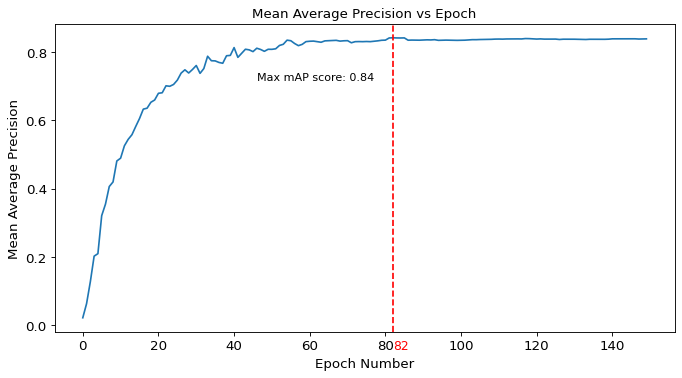

In [18]:
'''
Script used to read the csv file and make a graph of the mAP against epoch number
and mark the epoch where the mAP was maximised
'''
df = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/hyptrain10/results.csv")
# Find the maximum F1 score and its corresponding epoch
max_mAP_score = df["     metrics/mAP_0.5"].max()
max_mAP_score_epoch = df.loc[df["     metrics/mAP_0.5"] == max_mAP_score, '               epoch'].iloc[0]

# Create a plot of F1 score vs epoch
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(df['               epoch'], df["     metrics/mAP_0.5"])
plt.axvline(x=max_mAP_score_epoch, color="r", linestyle="--")
plt.xlabel("Epoch Number",fontsize = 12)
plt.ylabel("Mean Average Precision",fontsize = 12)
plt.title("Mean Average Precision vs Epoch")

# Get the x and y coordinates of the line for the maximum mAP score
line_x = plt.gca().lines[-2].get_xdata()
line_y = plt.gca().lines[-2].get_ydata()

# Get the index of the midpoint of the line
mid_idx = np.argmax(line_y)

# Get the x and y coordinates of the midpoint
mid_x = line_x[mid_idx]
mid_y = line_y[mid_idx]

# Move the text label downwards by a given value
label_offset= 0.1
plt.text(mid_x-5, mid_y-label_offset, f"Max mAP score: {max_mAP_score:.2f}",ha="right", va='top')
plt.text(mid_x+2,-0.07 , max_mAP_score_epoch,fontsize = 11,color = "r",ha="center")
plt.show()

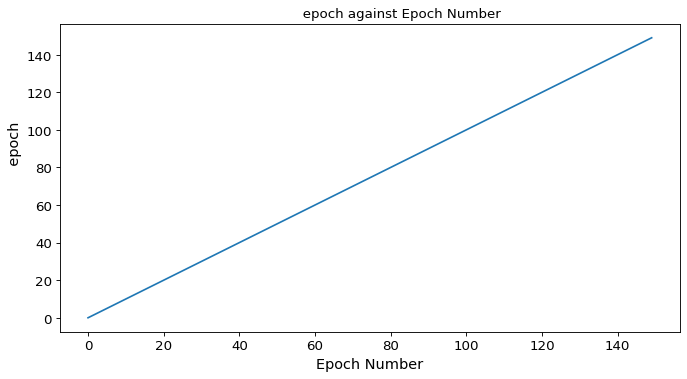

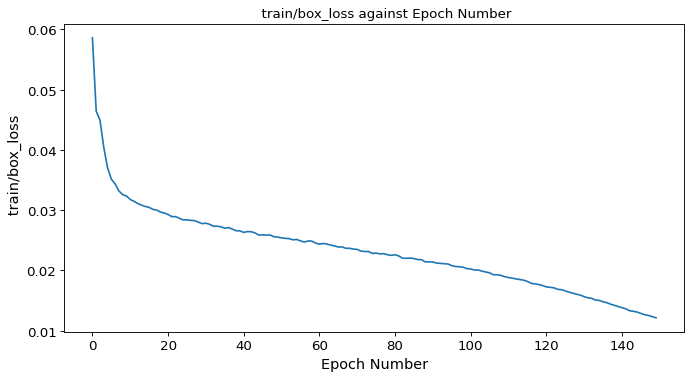

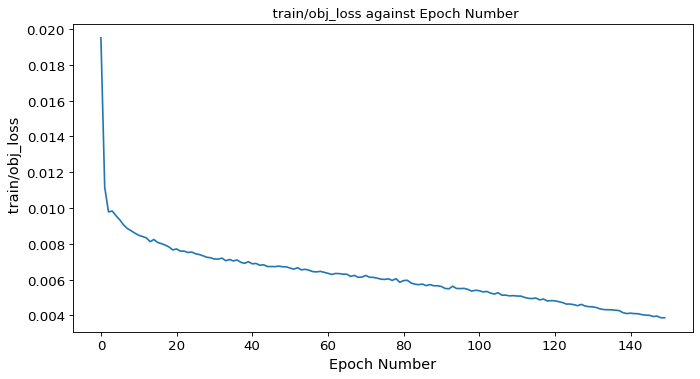

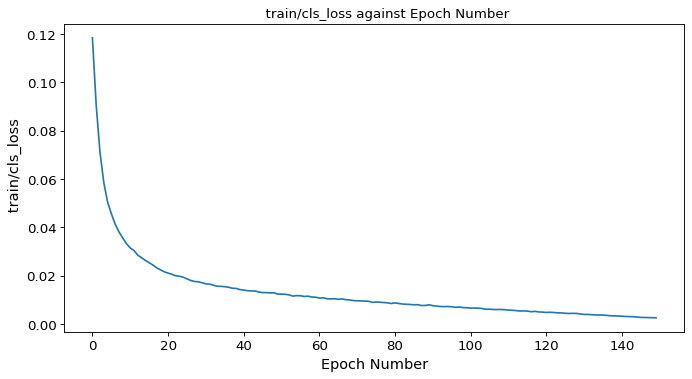

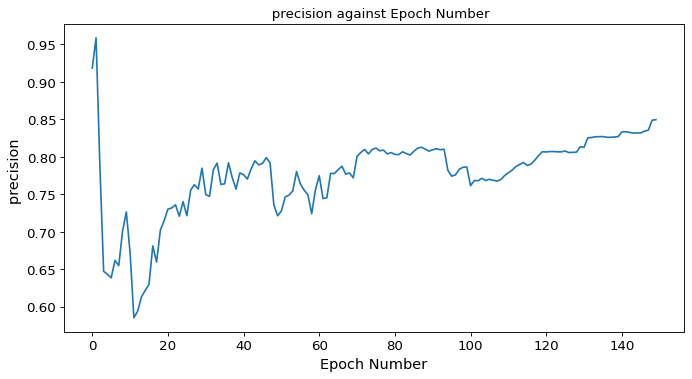

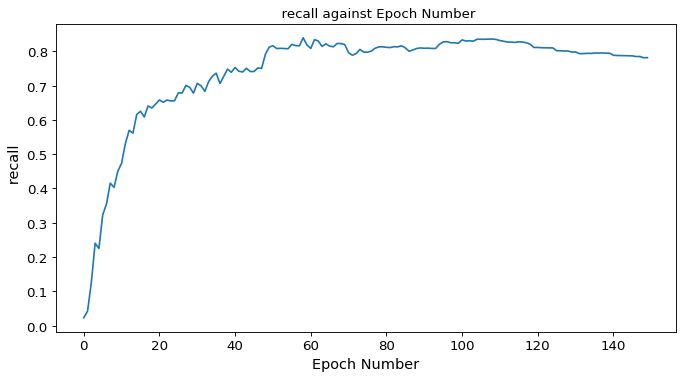

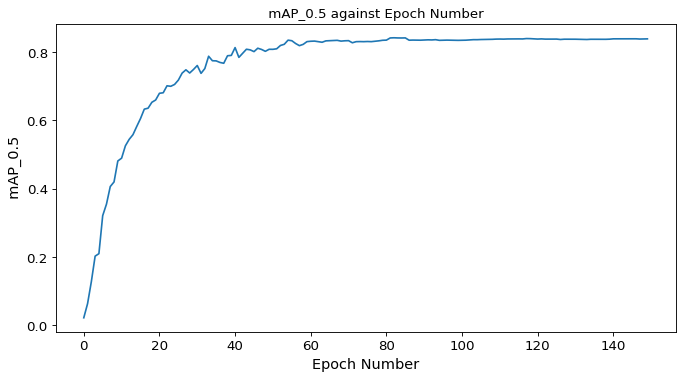

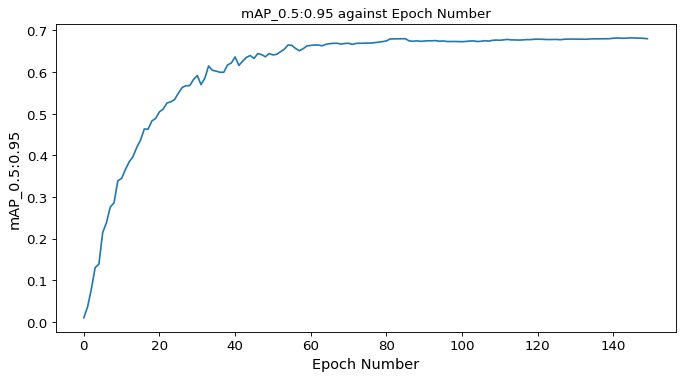

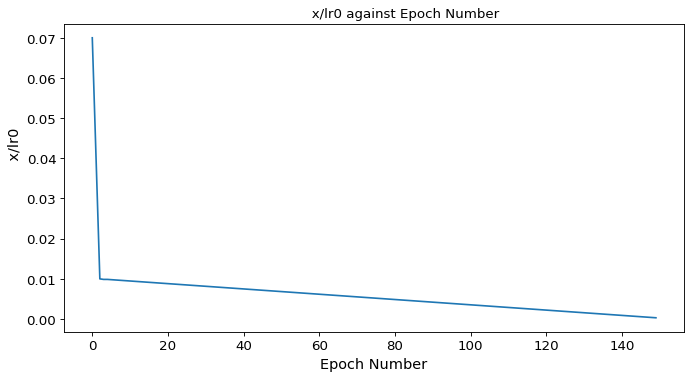

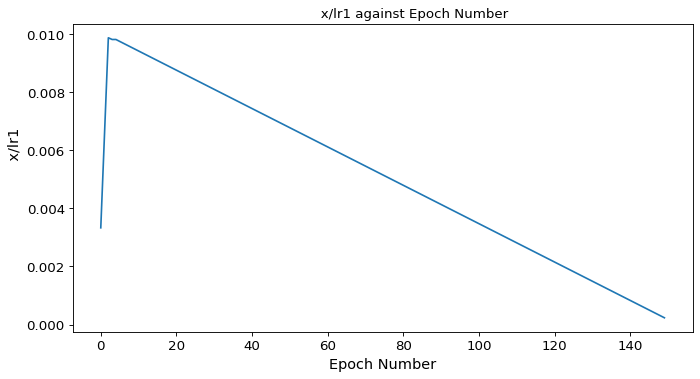

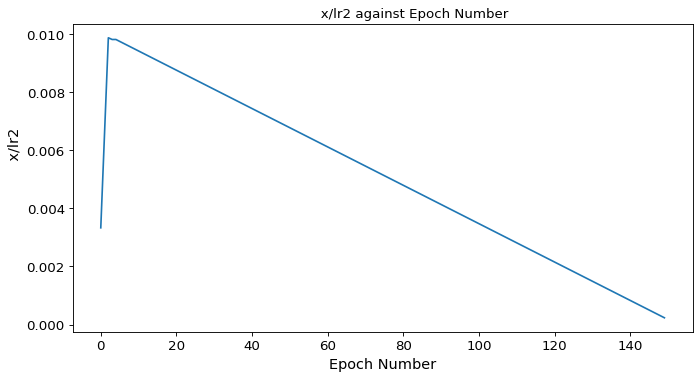

In [26]:
'''
Script used to create plots of all the columns in the csv file against epoch
number.
'''
# Define the epoch number column
epoch_col = '               epoch'

# Get a list of all column names that contain the "metrics/" string
y_cols = [col for col in df.columns if 'val' not in col]

# Create individual plots for each column
for col in y_cols:
  # Remove the "metrics/" string from the column name
  y_label = col.replace('metrics/', '')

  X = df[epoch_col]
  Y = df[col]

  plt.figure(figsize=(10,5), dpi=80)
  plt.xlabel("Epoch Number", fontsize=13)
  plt.ylabel(y_label, fontsize=13)
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.plot(X, Y)
  # Find the minimum value in the Y data
  min_val = min(Y)
  # Find the index of the minimum value in the Y data
  min_val_index = Y.idxmin()
  # Annotate the minimum value with its corresponding epoch number
  # plt.text(min_val_index-5, min_val, f"minimum value: {min_val:.5f}",ha="right", va='top')
  plt.title(f"{y_label} against Epoch Number")
  plt.show()

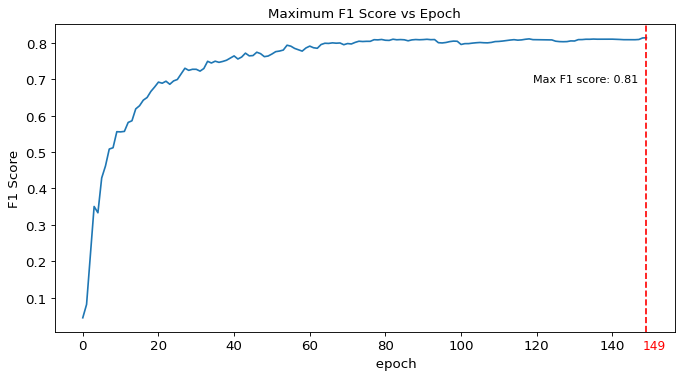

0.8141459083830941


In [8]:
'''
Script used to read the csv file and calculated the F1 score for each epoch and then 
make a graph of the F1 score against epoch number
and mark the epoch where the F1 score was maximised
'''
# Define columns for precision and recall
precision_col = "   metrics/precision"
recall_col = "      metrics/recall"


# Calculate F1 score and add it as a new column to the DataFrame
df["f1_score"] = 2 * ((df[precision_col] * df[recall_col]) / (df[precision_col] + df[recall_col]))

# Find the maximum F1 score and its corresponding epoch
max_f1_score = df["f1_score"].max()
max_f1_score_epoch = df.loc[df["f1_score"] == max_f1_score, '               epoch'].iloc[0]

# Create a plot of F1 score vs epoch
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(df['               epoch'], df["f1_score"])
plt.axvline(x=max_f1_score_epoch, color="r", linestyle="--")
plt.xlabel('               epoch',fontsize = 12)
plt.ylabel("F1 Score",fontsize = 12)
plt.title("Maximum F1 Score vs Epoch")

# Get the x and y coordinates of the line for the maximum F1 score
line_x = plt.gca().lines[-2].get_xdata()
line_y = plt.gca().lines[-2].get_ydata()

# Get the index of the midpoint of the line
mid_idx = np.argmax(line_y)

# Get the x and y coordinates of the midpoint
mid_x = line_x[mid_idx]
mid_y = line_y[mid_idx]

# Move the text label downwards by a given value
label_offset = 0.1
plt.text(mid_x-30, mid_y - label_offset, f"Max F1 score: {max_f1_score:.2f}", va='top')
plt.text(mid_x+2, -0.042, max_f1_score_epoch,fontsize = 11,color = "r",ha= "center")
plt.show()
print(max_f1_score)

===========================Hyperparameter evolution plots===========================

In [ ]:

# Read the csv file into a pandas dataframe
df = pd.read_csv("/content/drive/MyDrive/yolov5/runs/evolve/evolved9/results.csv")

# Add a generation number column based on the epoch number
df['Generation_Number'] = (df.index // 10) + 1
# Remove any zero data from the 5th column
df = df[df.iloc[:, 4] != 0]

# Create individual plots for each column of the 15th column against the 5:11th column
cols_to_plot = list(df.columns[1:12])
x_col = df.columns[14]

for col in cols_to_plot:
  if df[col].any():
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df.iloc[:, 14], df[col])
    plt.xlabel(x_col)
    col = col.replace("metrics/","").replace("train/","")
    plt.ylabel(col)
    plt.title(f"{col} vs {x_col}",fontsize = 14)
    plt.show()

In [ ]:
#Plotting epoch number vs mAP
df = pd.read_csv("/content/drive/MyDrive/yolov5/runs/train/exp8/results.csv")
X= df["               epoch"]
Y= df["     metrics/mAP_0.5"]
print(max(Y))
plt.figure(figsize=(10,5),dpi=80)
plt.xlabel("Epoch Number",fontsize=13)
plt.ylabel("Mean Average Precision",fontsize=13)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.plot(X,Y)
plt.show

# 18. Model Testing on images and Large Dataset (5.0)

===========================Processing Testing Dataset===========================

In [ ]:
# Creating correct directories for testing
os.mkdir("/content/Test/labels")
os.mkdir("/content/Test/jsonlabels")

In [ ]:
#Moving Testing labels into respective folder
os.chdir("/content/Test/images")
for i in os.listdir():
  shutil.copy("/content/Test/mtsd_v2_partially_annotated/annotations/"+ i.replace(".jpg",".json"),"/content/Test/jsonlabels")

In [ ]:
'''
Writing Class list yaml file- same as "labelstring" list made previously 
had to include this step to move list from Visual Studio Code to Colab:
'''
with open("/content/drive/MyDrive/RoadSignDataset/mtsd_v2_fully_annotated GREEN/labelclasses.txt") as f:
  class_list = f.readlines()
  class_list = [x.strip() for x in class_list]
print(class_list)

In [ ]:
'''
Defines a function that converts MTSD annotations into YOLOv5 .txt annotations
and moves these to a separate directory
'''
def labelwrite(path_to_img,dest_path):
  os.chdir(path_to_img)
  for file in os.listdir():
    # print("current file ="+ file)
    with open(file, "r") as j:
      data = json.load(j)
      w = open(str(file).replace("json","txt"), "w")
      w.write("")
      w.close
      for instance in range(0,len(data["objects"])):
        with open(str(file).replace("json","txt"),"a") as t:
          x= ((float(data["objects"][instance]["bbox"]["xmax"])+float(data["objects"][instance]["bbox"]["xmin"]))/2)/float(data["width"])
          y= ((float(data["objects"][instance]["bbox"]["ymax"])+float(data["objects"][instance]["bbox"]["ymin"]))/2)/float(data["height"])
          width= (float(data["objects"][instance]["bbox"]["xmax"])-float(data["objects"][instance]["bbox"]["xmin"]))/float(data["width"])
          height= (float(data["objects"][instance]["bbox"]["ymax"])-float(data["objects"][instance]["bbox"]["ymin"]))/float(data["height"])

          t.write(str(class_list.index(data["objects"][instance]["label"]))+" "+ str(x) + " "+ str(y) + " " + str(width) + " " + str(height) +"\n")
    shutil.move(str(file).replace("json","txt"),dest_path)

In [ ]:
labelwrite("/content/Test/jsonlabels","/content/Test/labels")

In [ ]:
os.chdir("/content/Test/labels")
# Checking how many images were removed
Original_Size = len(os.listdir())
for filename in os.listdir():
  with open(str(filename),"r") as file:
    with open("temp.txt","w") as output:
      for line in file:
        word_split = line.split()
        if int(word_split[0]) not in unusedclasslist:
          output.write(line)
  os.replace("temp.txt",str(filename))
  if os.path.getsize(str(filename)) ==0:
    os.remove(str(filename))
Updated_Size = len(os.listdir())
print("Number of files removed = {}".format(int(Original_Size-Updated_Size)))

In [ ]:
#Removing all unlabelled training images
os.chdir("/content/Test/images")
numberofremovedimages = 0
for image in os.listdir():
  os.chdir("/content/Test/labels")
  if os.path.exists(str(image).replace(".jpg",".txt")) ==False:
    os.chdir("/content/Test/images")
    os.remove(image)
    numberofremovedimages +=1
  else:
    os.chdir("/content/Test/images")
print(numberofremovedimages)

In [ ]:
# Removing a faulty image from the dataset
os.remove("/content/Test/labels/5TTRQQ_FF_6j2b2P425Jmw.txt")
os.remove("/content/Test/images/5TTRQQ_FF_6j2b2P425Jmw.jpg")

In [ ]:
# Cropping testing images using the hybrid cropping method
crop_img("/content/Test/images")

In [ ]:
#Finding the image properties of the testing dataset

test_crop_height,test_crop_width,test_crop_Area = get_img_size("/content/Test/images")

#Finding size for scaling:
quantile_num = 0.2
print(str(quantile_num) + " quantile of image height: {}".format(np.quantile(test_crop_height, quantile_num)))
print(str(quantile_num) +" quantile of image width: {}".format(np.quantile(test_crop_width, quantile_num)))
print("Standard Deviation of image width: {}".format(np.std(test_crop_width)))
print("Standard Deviation of image height: {}".format(np.std(test_crop_height)))
print("Standard Deviation of image area: {}".format(np.std(test_crop_Area)))
X = test_crop_height
Y = test_crop_width
columns = ["Height","Width"]
# Creating Boxplot of Height and Width

# Creating a pandas dataframe to allow multiple boxplots on one figure
df = pd.DataFrame(list(zip(X,Y)),columns = columns)

fig, ax = plt.subplots(figsize = (20,6))
sns.boxplot(data = df, width = 0.4, ax = ax, palette= "Blues")
sns.color_palette("husl",1)
# boxplot = sns.stripplot(data= df, marker="o", alpha=0.1, color="red", s=5)

In [ ]:
testiterationname = "Single_img3"

In [ ]:
'''
Command used for large dataset testing
'''

#Detecting on test dataset
os.chdir("/content/drive/MyDrive/yolov5")
# !python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/exp11_AfterCropping/weights/best.pt --source /content/Test/images --img 672 --save-txt --save-conf --name testiterationname --conf-thres 0.6

detect: weights=['/content/drive/MyDrive/yolov5/runs/train/exp11_AfterCropping/weights/best.pt'], source=/content/Test/images/F-PDQoCKynKS6bOfQKpYJA.jpg, data=data/coco128.yaml, imgsz=[500, 500], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=True, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-10-g10c025d Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 212 layers, 22469334 parameters, 0 gradients, 53.0 GFLOPs
WARNING ⚠️ --img-size [500, 500] must be multiple of max stride 32, updating to [512, 512]
image 1/1 /content/Test/images/F-PDQoCKynKS6bOfQKpYJA.jpg: 320x512 (no detections), 86.2ms
Speed: 0.5ms pre-process, 86.2ms inference, 0.5ms NMS per image at shape (1, 3,

In [ ]:
'''
Testing code on single images, used for the robustness testing
'''
os.chdir("/content/drive/MyDrive/yolov5")
Path_to_img = "/content/Stop_blocked.png"
!python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/exp11_AfterCropping/weights/best.pt --source /content/Snow_StopSign.jpeg --img 412 --save-txt --name "Stop_Blocked_Snow"

In [ ]:
'''

A copy of the final algorithm python script. This will not work in Colab as the 
webcam usage is not permitted. This is copied from Visual Studio Code



import torch
import cv2
import numpy as np
import pyttsx3
import pafy
import pandas as pd
import time

# Loads the PyTorch model and yolov5 repository for exporting information
model = torch.hub.load('ultralytics/yolov5', 'custom', path= "best.pt")
model.eval()
previous_label = None
frame_count = 0
# Initialises the text-to-speech algorithm
engine = pyttsx3.init()

# Defining the function to create and narrate predictions
def predict(frame):
    global previous_label, frame_count
    # resizing the frame to a square image, matching the input size of the model
    resized_frame = cv2.resize(frame,(1248,1248))
    # Creating predictions and store them
    results = model(frame)
    #Creates a pandas dataframe that stores all predictions, confidences and locations for bounding box
    df = results.pandas().xyxy[0]

    # Storing the labels for each prediction
    labels = {1: 'regulatory--keep-right--g1',
        2: 'regulatory--priority-over-oncoming-vehicles--g1',
        4: 'regulatory--maximum-speed-limit-35--g2',
        6: 'warning--curve-left--g2',
        9: 'warning--pedestrians-crossing--g4',
        12: 'regulatory--maximum-speed-limit-45--g3',
        14: 'regulatory--one-way-right--g2',
        15: 'regulatory--yield--g1',
        16: 'regulatory--one-way-straight--g1',
        17: 'warning--curve-right--g1',
        18: 'regulatory--pedestrians-only--g2',
        20: 'regulatory--no-entry--g1',
        23: 'warning--crossroads--g3',
        26: 'regulatory--no-stopping--g15',
        38: 'regulatory--no-overtaking--g2',
        41: 'regulatory--stop--g1',
        43: 'regulatory--maximum-speed-limit-30--g1',
        48: 'regulatory--end-of-maximum-speed-limit-30--g2',
        52: 'warning--height-restriction--g2',
        54: 'warning--double-curve-first-left--g2',
        58: 'regulatory--turn-right--g1',
        60: 'regulatory--turn-left--g1',
        61: 'regulatory--no-parking-or-no-stopping--g3',
        62: 'warning--roundabout--g1',
        64: 'regulatory--maximqum-speed-limit-60--g1',
        66: 'regulatory--maximum-speed-limit-40--g1',
        69: 'warning--road-bump--g1',
        70: 'warning--uneven-road--g6',
        71: 'regulatory--maximum-speed-limit-50--g1',
        72: 'regulatory--no-parking--g5',
        76: 'regulatory--maximum-speed-limit-100--g1',
        78: 'regulatory--maximum-speed-limit-5--g1',
        81: 'warning--children--g2',
        83: 'regulatory--no-u-turn--g3',
        87: 'regulatory--go-straight-or-turn-left--g1',
        88: 'regulatory--bicycles-only--g1',
        90: 'regulatory--one-way-left--g1',
        93: 'regulatory--give-way-to-oncoming-traffic--g1',
        97: 'warning--narrow-bridge--g1',
        98: 'regulatory--turn-right-ahead--g1',
        100: 'regulatory--maximum-speed-limit-70--g1',
        103: 'regulatory--pass-on-either-side--g2',
        111: 'regulatory--u-turn--g1',
        112: 'regulatory--keep-left--g1',
        113: 'regulatory--go-straight--g1',
        118: 'regulatory--road-closed-to-vehicles--g3',
        119: 'regulatory--no-left-turn--g3',
        122: 'regulatory--no-right-turn--g1',
        129: 'regulatory--maximum-speed-limit-90--g1',
        130: 'regulatory--maximum-speed-limit-110--g1',
        136: 'warning--winding-road-first-left--g1',
        137: 'warning--turn-right--g1',
        144: 'warning--traffic-signals--g3',
        149: 'warning--winding-road-first-right--g3',
        154: 'regulatory--maximum-speed-limit-20--g1',
        155: 'regulatory--maximum-speed-limit-25--g2',
        156: 'regulatory--no-motor-vehicles-except-motorcycles--g2',
        172: 'regulatory--maximum-speed-limit-55--g2',
        175: 'warning--pass-left-or-right--g2',
        180: 'regulatory--maximum-speed-limit-80--g1',
        183: 'warning--roadworks--g1',
        193: 'regulatory--road-closed--g2',
        197: 'warning--school-zone--g2',
        211: 'regulatory--no-turn-on-red--g1',
        213: 'warning--road-narrows-right--g1',
        225: 'regulatory--maximum-speed-limit-led-100--g1',
        227: 'regulatory--maximum-speed-limit-10--g1',
        233: 'regulatory--roundabout--g1',
        236: 'warning--bicycles-crossing--g1',
        241: 'warning--turn-left--g1',
        243: 'warning--stop-ahead--g9',
        244: 'regulatory--mopeds-and-bicycles-only--g1',
        245: 'regulatory--end-of-speed-limit-zone--g1',
        256: 'regulatory--no-motor-vehicles--g1',
        262: 'regulatory--no-straight-through--g1',
        264: 'warning--offset-roads--g3',
        265: 'regulatory--maximum-speed-limit-120--g1',
        266: 'regulatory--go-straight-or-turn-right--g3',
        271: 'regulatory--buses-only--g1',
        283: 'regulatory--maximum-speed-limit-led-80--g1',
        291: 'warning--road-widens-right--g1',
        299: 'regulatory--end-of-maximum-speed-limit-70--g2',
        300: 'warning--traffic-merges-left--g2',
        307: 'regulatory--minimum-safe-distance--g1',
        314: 'regulatory--stop-signals--g1',
        320: 'regulatory--width-limit--g1',
        326: 'regulatory--no-turns--g1',
        327: 'regulatory--maximum-speed-limit-15--g1',
        329: 'regulatory--maximum-speed-limit-led-60--g1',
        337: 'warning--two-way-traffic--g2',
        357: 'warning--road-narrows-left--g1',
        363: 'regulatory--maximum-speed-limit-65--g2',
        392: 'warning--restricted-zone--g1'}
    #Reads all valid predictions
    if pd.api.types.is_numeric_dtype(df["class"]):
        if (df["class"]% 1 ==0).all():

            #Stores all classes and their confidences to find the prediction with the maximum confidence
            confidences = []
            for i in df["confidence"]:
                confidences.append(float(i))
                max_conf = max(confidences)

            #Applies a threshold for the maximum confidence 
            if max_conf >=0.7:

                # Formats the best prediction a string for the text-to-speech engine
                current_prediction =df.loc[df['confidence'] == max_conf,'class'].values[0]
                text = labels[int(current_prediction)]
                text = text.split("--")
                text = str("{} Sign Detected".format(text[1]))

                #Checks if the best prediction has been read in the last 20 frames (10 seconds)
                if text == previous_label:
                    frame_count += 1
                else:
                    previous_label = text
                    frame_count = 0
                if frame_count >= 20:
                    frame_count = 0
                
                #Narrates the best prediction
                if frame_count == 0:
                    engine.say(text)
                    engine.runAndWait()
            
# Initializes the video
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer= cv2.VideoWriter('basicvideo.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
# Loops over teach frame of the video
numberofframes = 0
start = time.time()
while True:
    numberofframes += 1
    # Reads each frame
    ret, frame = cap.read()

    # Checks if the frame was successfully read
    if not ret:
        break

    # Showing the frame in a window - used for illustrating testing but can comment out
    cv2.imshow("frame", frame)
    # Make a prediction and narrate the results
    predict(frame)

    # Check if the user has pressed the "q" key to terminate the while loop
    if cv2.waitKey(1) == ord("q"):
        break
# Terminates the video
cap.release()
cv2.destroyAllWindows()
# Calculates the duration and framerate
duration = time.time() -start
print(duration)
framerate = numberofframes// duration
print("Framerate: ",framerate)


'''

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-15 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Model summary: 212 layers, 22469334 parameters, 0 gradients, 53.0 GFLOPs
Adding AutoShape... 


0.0002315044403076172
Framerate:  4319.0


# 19. Analysis of Results (5.0)

---
---
Creating Confusion Matrix

---
---

In [ ]:
'''
Creating an empty pandas dataframe that will be filled with the testing 
results. The column names, including background are then added to the column 
names
'''
#Defining Row and Column names for a tempoary row column name variable which
# will make mapping labels easier

confusionmatrix_rowcolumn_list = ["Background"]
final_confusionmatrix_rowcolum_list = ["Background"]
for i in name_key_dict:
  confusionmatrix_rowcolumn_list.append(i)
  
#Defining final row and column names. This will replace the temporary values once
# all values in the matrix have been filled
for i in name_key_dict:
  name = str(name_key_dict[i]+"("+str(i)+")")
  final_confusionmatrix_rowcolum_list.append(name)

os.chdir("/content/Test/labels")

df = pd.DataFrame(columns = confusionmatrix_rowcolumn_list,index = confusionmatrix_rowcolumn_list)
df.fillna(0, inplace = True)
df
#The x axis is actual predictions, the y axis is predicted positive

,Background,4,6,9,12,14,15,16,18,20,...,307,314,320,326,327,329,337,357,363,392
Background,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
'''
Defines a function to check if two lists have common elements, used in the next
script
'''
def have_common_elements(list1, list2):
    common_elements = list(set(list1) & set(list2))
    return common_elements


In [ ]:
'''
Populating the confusion matrix with testing results.
Correct predictions are first checked for each image's predicted and actual 
annotations. The script then determines if the incorrect predictions are
background detections or wrong class predictions
'''

#Populating confusion matrix
number_of_exceptions = 0
#Iterating over all files in Test/labels Directory
for file in os.listdir("/content/Test/labels"):
  actualclasspredictions = []
  predictedclasses = []
  number_of_exceptions = 0
  insertedintomatrix = []
  testiterationname = "Large_test_withcrop"
  #Opens each label .txt file and reads it
  with open(file,"r") as actual:
    #checks if associated .txt file exists in the detected folder and if so, reads it too
    if os.path.exists("/content/drive/MyDrive/yolov5/runs/detect/"+testiterationname+"/labels/"+file) == True:

      with open("/content/drive/MyDrive/yolov5/runs/detect/"+testiterationname+"/labels/"+file) as predicted:
        #Parsing actual and predicted annotations
        for line in actual:
          word_split = line.split()
          actualclasspredictions.append(int(word_split[0]))

        for line in predicted:
          word_split = line.split()
          predictedclasses.append(int(word_split[0]))
        #Ensures there are no repeated elements, this can occur from poor IOU Thresholding but should be ignored
        predictedclasses = set(predictedclasses)
        actualclasspredictions = set(actualclasspredictions)
        correct_predictions = have_common_elements(predictedclasses,actualclasspredictions)
        #Checks for any correct predictions
        if bool(correct_predictions):
          for i in correct_predictions:
            df.loc[i,i] += 1
            insertedintomatrix.append(i)
            #Removes classes to ensure they are not checked again
            actualclasspredictions.remove(i)
            predictedclasses.remove(i)
        
        wrongpredictions = [x for x in predictedclasses if x not in actualclasspredictions]
        missedpredictions = [x for x in actualclasspredictions if x not in predictedclasses]
        if len(actualclasspredictions) <= len(predictedclasses):
          for j in predictedclasses:
            if j not in insertedintomatrix:
              #If there are remainer actual classes that were not predicted and unpaired where pairs remain
              for i in actualclasspredictions:
                if i not in insertedintomatrix:
                  try:
                    df.loc[j,i] +=1
                  except Exception as e:
                    number_of_exceptions += 1
                  insertedintomatrix.append(i)
                  insertedintomatrix.append(j)
              #If there are no remainder actual classes but still unpaired predicted
              if j not in actualclasspredictions and j not in insertedintomatrix:
                df.loc[j,"Background"] +=1
                try:
                  df.loc[j,i] += 1
                except Exception as e:
                  number_of_exceptions += 1
                insertedintomatrix.append(j)


        elif len(predictedclasses) < len(actualclasspredictions):
          for i in actualclasspredictions:
            if i not in insertedintomatrix:        
              for j in predictedclasses:
                if j not in insertedintomatrix:

                  try:
                    df.loc[j,i] +=1
                    insertedintomatrix.append(i)
                    insertedintomatrix.append(j)
                  except Exception as e:
                    number_of_exceptions += 1
                  insertedintomatrix.append(i)
                  insertedintomatrix.append(j)
                else:
                  try:
                    df.loc["Background",i] +=1
                    insertedintomatrix.append(i)
                    insertedintomatrix.append(j)
                  except Exception as e:
                    number_of_exceptions += 1
                  insertedintomatrix.append(i)
                  insertedintomatrix.append(j)

In [ ]:
#Visualising Complete Confusion Matrix
sns.heatmap(df, cmap='coolwarm')
df.to_csv("/content/drive/MyDrive/yolov5/runs/detect/"+testiterationname+"/heatmap.csv")

In [ ]:
#Finding total correct predictions
total_correct = 0
for i in confusionmatrix_rowcolumn_list:
  total_correct += df.loc[i,i]
total_predictions = df.values.sum()

In [ ]:
#Finding percentage of correct predictions
total_correct/total_predictions

In [ ]:
df.loc[1,1]

Calculating F1 Score from confusion matrix

In [ ]:
'''
Calculating F1 Score from confusion matrix
'''

# Calculate the number of classes, accounting for the background class
n_classes = df.shape[0] - 1
f1_scores = []


for i in df.columns:
  # Ignores the backgoround class
  if i == "Background":
    continue
  else:
    # extracts the true positives, false positives, and false negatives for the class
    tp = df.loc[i, i]
    fp = df.loc[:, i].sum() - tp
    fn = df.loc[i, :].sum() - tp
    
    # calculates the f1 score for the class and appends to a list
    precision_score = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision_score*recall)/(precision_score+recall)
    f1_scores.append(f1)

# Calcuating the average f1 score
avg_f1_score = np.nanmean(f1_scores)

# prints the f1 score and average f1 score
print('F1 scores:', f1_scores)
print('Average F1 score (excluding background class):', avg_f1_score)

In [ ]:
# Reading the csv file as a pandas dataframe and displaying it
# cm = pd.read_csv("/content/drive/MyDrive/yolov5/runs/detect/Single_img3/heatmap.csv",index_col=0)
cm = pd.read_csv("/content/temp.csv",index_col=0)
cm

In [ ]:
'''
Creating 2-Dimensional Confusion Matrix for Visualisation Purposes in the report
and calculating the F1 score
'''

truepos = 0
falsepos = 0
falseneg = 0
trueneg = 0
f1_scores = []
for i in cm.columns:
  if i == "Background":
    continue
  # extracts the true positives, false positives, and false negatives for the class
  tp = cm.loc[i, i]
  fp = cm.loc[:, i].sum() - tp
  fn = cm.loc[i, :].sum() - tp
  truepos += tp
  falsepos += fp
  falseneg += fn
  
  # calculate precision score
  if tp + fp == 0 or tp + fn ==0:
    continue
  else:
    precision_score = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision_score*recall)/(precision_score+recall)

# appends the score to the list
  f1_scores.append(f1)

# calculates the average f1 score for all classes, excluding the background class
avg_f1_score = np.nanmean(f1_scores)

# prints the f1 score and average f1 score
print('Average F1 score (excluding background class):', avg_f1_score)
twodmatrix =  [[truepos,falsepos],
               [falseneg,trueneg]]
twodmatrix = np.array(twodmatrix)
precision_scoretd = truepos/(truepos+falsepos)
recalltd = truepos/(truepos+falseneg)
f1td = (2*precision_scoretd*recalltd)/(precision_scoretd+recalltd)
print("2d matrix f1 score",f1td)
print(falseneg)
precision_score=0
recall = 0

precision_score = truepos/(truepos+fp)
recall = truepos/(truepos+fn)
f1 = (2*precision_score*recall)/(precision_score+recall)

Average F1 score (excluding background class): 0.7230850533168396
2d matrix f1 score 0.7110548790131268
2634


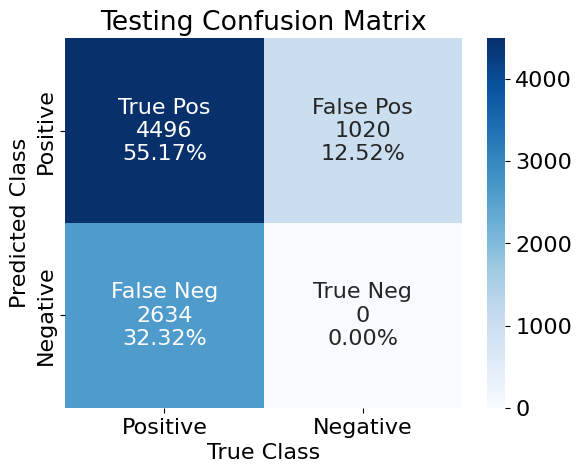

In [ ]:
'''
Displaying the 2-D Confusion matrix
'''

# Defines group names, axis labels, and group counts for the heatmap
group_names = ["True Pos","False Pos","False Neg","True Neg"]
x_axis_labels = ["Positive","Negative"]
y_axis_labels = ["Positive","Negative"]

# Gets the counts and percentages
group_counts = ["{0:0.0f}".format(value) for value in twodmatrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in twodmatrix.flatten()/np.sum(twodmatrix)]

# Creates labels for each cell in the heatmap
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Displaying the heatmap in seaborn
sns.heatmap(twodmatrix, annot=labels, fmt="", cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Testing Confusion Matrix")
plt.show()

In [ ]:
uncommon_classes

['392']

======================Creating the final confusion matrix======================

In [ ]:
# Reads the result confunsion matrix
df = pd.read_csv("/content/temp.csv")
len(df.columns)

65

In [ ]:
'''
Reads the final confusion matrix and creates smaller csv files for each small confusion matrix
'''

os.chdir("/content")
if os.path.exists("csv files") ==True:
  shutil.rmtree("csv files")
os.mkdir("csv files")
# Reads CSV file containing confusion matrix with class labels
confusion_matrix_df = pd.read_csv("/content/temp.csv", index_col=0)
confusion_matrices = {}

# Extracts confusion matrix values from the DataFrame
confusion_matrix = confusion_matrix_df.values

# Defines the number of classes to display in each confusion matrix
num_display = 10

# Calculates the number of confusion matrices to display
num_matrices = int(np.ceil((confusion_matrix.shape[0] - 1) / num_display))

# Loops through the confusion matrix and display each section as a separate confusion matrix
for i in range(num_matrices):
  # Calculates the starting and ending indices for the rows and columns of the current section
  start_idx = i * num_display + 1
  end_idx = min(start_idx + num_display, confusion_matrix.shape[0])
  num_classes_curr = end_idx - start_idx

  # Adds background class to the confusion matrix
  bg_confusion_matrix = np.zeros((num_classes_curr+1, num_classes_curr+1))

  # Adds values 
  bg_confusion_matrix[1:, 1:] = confusion_matrix[start_idx:end_idx, start_idx:end_idx]

  # Add up the row and column values for the background class
  bg_confusion_matrix[0, 1:] = confusion_matrix[0, start_idx:end_idx]
  bg_confusion_matrix[1:, 0] = confusion_matrix[start_idx:end_idx, 0]
  class_types = ["Background"] + [str(x) for x in confusion_matrix_df.columns[start_idx:end_idx]]
  confusion_matrixdf = pd.DataFrame(bg_confusion_matrix,columns = class_types,index = class_types)
  # matrixname= str("confusion_matrixdf")
  
  # Saves the smaller confusion matrix as a separate csv file
  confusion_matrixdf.to_csv(str("/content/csv files/confusion_matrixdf {}.csv".format(i)))
  print(confusion_matrixdf)


            Background    1    2     4     6      9    12    14     15     16  \
Background         0.0  0.0  0.0   0.0   0.0    0.0   1.0   0.0    0.0    0.0   
1                  0.0  0.0  0.0   0.0   0.0    0.0   0.0   0.0    0.0    0.0   
2                  0.0  0.0  0.0   0.0   0.0    0.0   0.0   0.0    0.0    0.0   
4                  6.0  0.0  0.0  69.0   0.0    0.0   1.0   0.0    0.0    0.0   
6                 43.0  0.0  0.0   0.0  98.0    0.0   4.0   0.0    0.0    0.0   
9                 48.0  0.0  0.0   2.0   0.0  165.0   2.0   0.0    5.0    0.0   
12                21.0  0.0  0.0   0.0   0.0    1.0  68.0   0.0    0.0    0.0   
14               103.0  0.0  0.0   5.0   0.0    3.0   2.0  65.0   10.0    0.0   
15               169.0  0.0  0.0   2.0   0.0    3.0   0.0   0.0  486.0    0.0   
16                60.0  0.0  0.0   0.0   0.0    1.0   0.0   0.0    4.0  101.0   
17                 0.0  0.0  0.0   0.0   0.0    0.0   0.0   0.0    0.0    0.0   

             17  
Backgroun

In [ ]:
'''
Creates heatmaps used for visualising the confusion matrices
'''
def create_heatmaps(directory):
  
  # Get a list of all the .csv files in the directory
  files = os.listdir(directory)
  csv_files = [file for file in files if file.endswith('.csv')]

  for file in csv_files:

    data = pd.read_csv(directory + file, index_col=0)
    classes = [int(c) for c in data.columns if c != 'Background']
    class_range = f"classes {min(classes)} to {max(classes)}"

    # Create the heatmap using seaborn
    sns.heatmap(data, cmap='Blues', annot=True, fmt='g', annot_kws={'fontsize': 12})
    plt.title(f"Confusion Matrix for {class_range}", y=1.05)
    plt.figure(figsize=(10, 18))

    # Save the plot as a .png file with the class range as the name
    plt.subplots_adjust(top=45)
    plt.savefig(directory + class_range + '.png', bbox_inches='tight')
    plt.show()

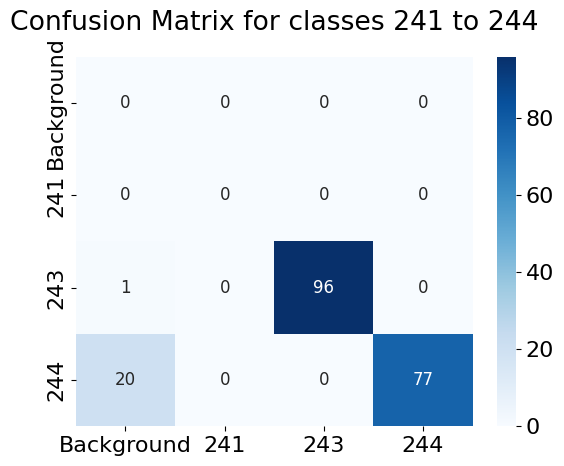

<Figure size 1000x1800 with 0 Axes>

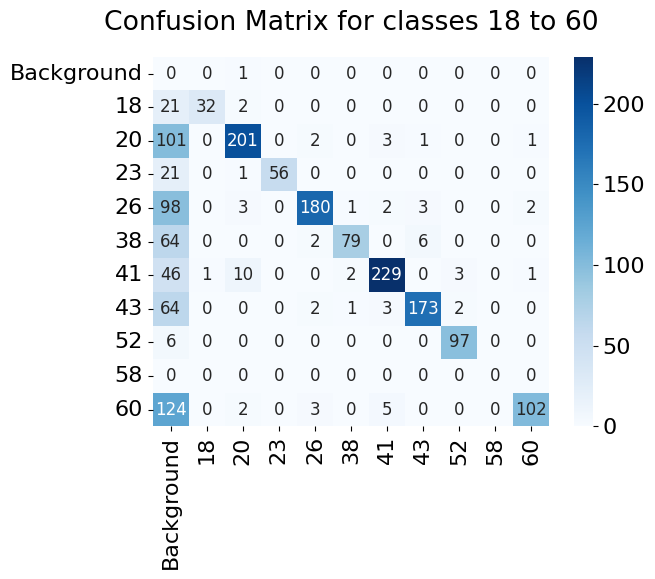

<Figure size 1000x1800 with 0 Axes>

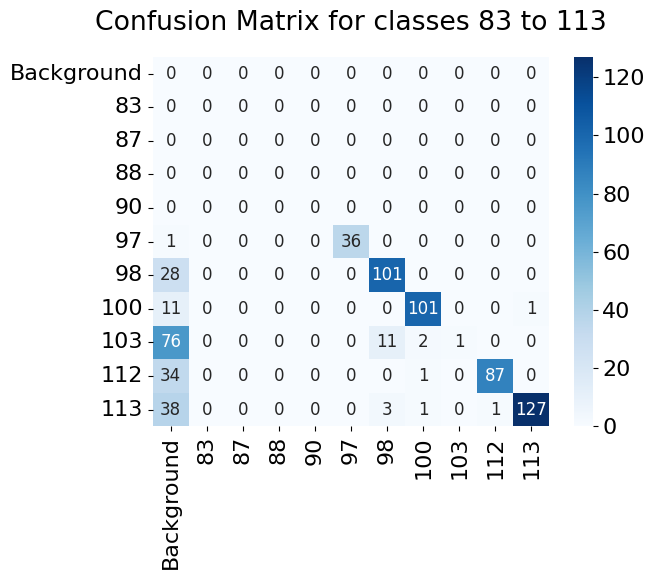

<Figure size 1000x1800 with 0 Axes>

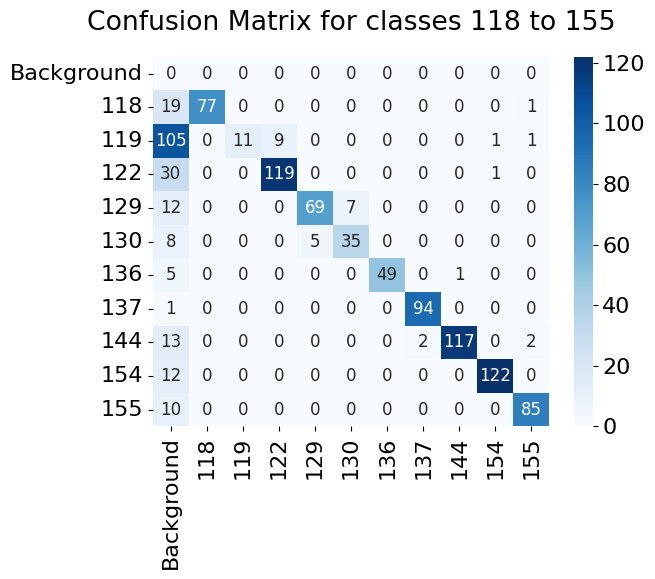

<Figure size 1000x1800 with 0 Axes>

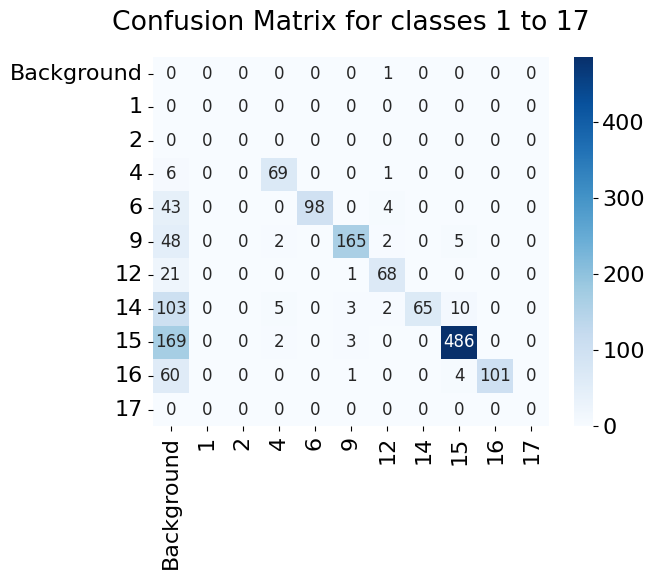

<Figure size 1000x1800 with 0 Axes>

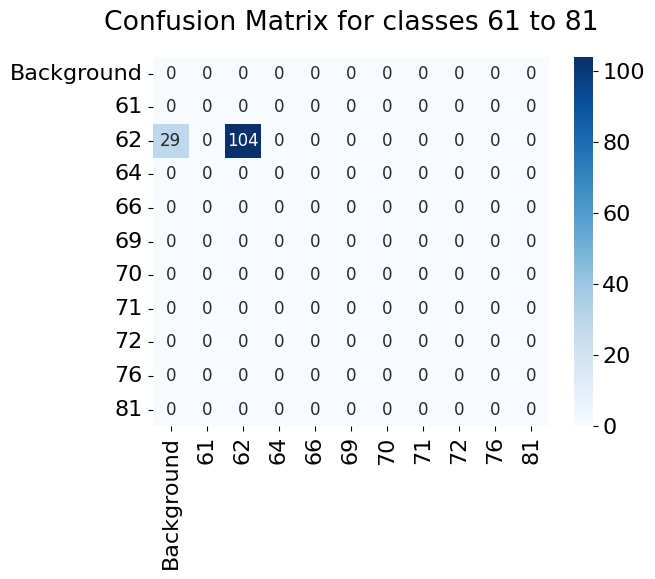

<Figure size 1000x1800 with 0 Axes>

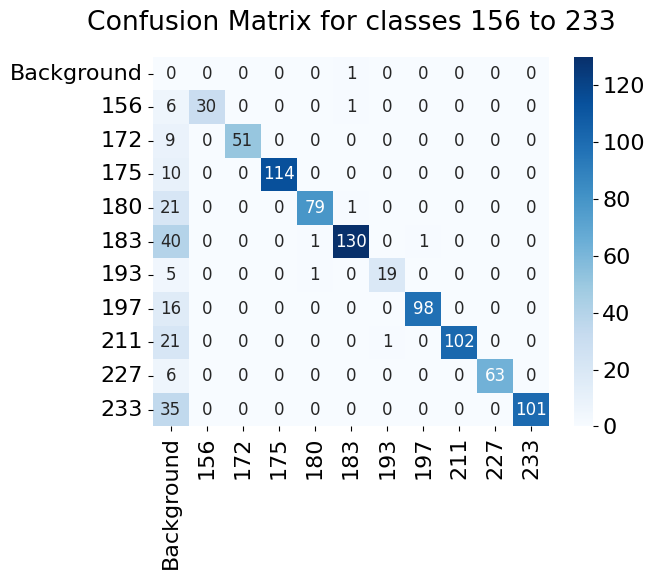

<Figure size 1000x1800 with 0 Axes>

In [ ]:
create_heatmaps("/content/csv files/")